In [11]:
# ═══ PREREQUISITES FOR CBC BIOMARKER ANALYSIS ═══
# Run this cell first to create the required datasets

import duckdb
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import combinations

# ─── 1) DATABASE SETUP ─────────────────────────────────────────────────────
print("=== SETTING UP MIMIC-IV DATABASE CONNECTION ===")

con = duckdb.connect()

# Set your data directory path
DATA_DIR = Path("/Users/dimitri/Desktop/indi/data/mimic-iv-3.1")
p = lambda f: str(DATA_DIR / f)

print(f"Data directory: {DATA_DIR}")

# ─── 2) CORE VIEWS SETUP ───────────────────────────────────────────────────
print("\n1. Creating core database views...")

# Patients view
con.execute(f"""
CREATE OR REPLACE VIEW patients AS
SELECT subject_id, anchor_year, anchor_year_group, dod
FROM read_csv_auto('{p('hosp/patients.csv.gz')}');
""")

# ICU stays view  
con.execute(f"""
CREATE OR REPLACE VIEW icustays AS
SELECT subject_id, hadm_id, stay_id, intime, outtime,
       EXTRACT(epoch FROM (outtime - intime))/3600 AS los_hours
FROM read_csv_auto('{p('icu/icustays.csv.gz')}');
""")

# Diagnoses view (needed for disease stratification)
con.execute(f"""
CREATE OR REPLACE VIEW diagnoses AS
SELECT hadm_id, icd_version, icd_code
FROM read_csv_auto('{p('hosp/diagnoses_icd.csv.gz')}');
""")

print("✓ Core views created")

# ─── 3) CBC DATA EXTRACTION ────────────────────────────────────────────────
print("\n2. Extracting CBC data from labevents...")

# Create enhanced CBC table with outcomes
con.execute(f"""
CREATE OR REPLACE TABLE enhanced_cbc AS
SELECT
  i.stay_id, i.hadm_id, i.los_hours,
  -- Admission CBC values (first 24h) 
  MIN(CASE WHEN l.itemid = 51222 THEN l.valuenum END) AS hb,
  MIN(CASE WHEN l.itemid = 51221 THEN l.valuenum END) AS hct,
  MIN(CASE WHEN l.itemid = 51250 THEN l.valuenum END) AS mcv,
  MIN(CASE WHEN l.itemid = 51248 THEN l.valuenum END) AS mch,
  MIN(CASE WHEN l.itemid = 51249 THEN l.valuenum END) AS mchc,
  MIN(CASE WHEN l.itemid = 51277 THEN l.valuenum END) AS rdw,
  MIN(CASE WHEN l.itemid = 51279 THEN l.valuenum END) AS rbc,
  MIN(CASE WHEN l.itemid = 51265 THEN l.valuenum END) AS platelet,
  MIN(CASE WHEN l.itemid = 51301 THEN l.valuenum END) AS wbc,
  MIN(CASE WHEN l.itemid = 51256 THEN l.valuenum END) AS neutrophils,
  MIN(CASE WHEN l.itemid = 51244 THEN l.valuenum END) AS lymphocytes,
  MIN(CASE WHEN l.itemid = 51254 THEN l.valuenum END) AS monocytes,
  -- Outcomes
  CASE WHEN p.dod IS NOT NULL AND p.dod <= i.outtime + INTERVAL '30' DAY 
       THEN 1 ELSE 0 END AS mort_30d,
  CASE WHEN i.los_hours > 72 THEN 1 ELSE 0 END AS prolonged_stay
FROM read_csv_auto('{p('hosp/labevents.csv.gz')}') AS l
JOIN icustays i USING(hadm_id)
JOIN patients p ON i.subject_id = p.subject_id
WHERE l.itemid IN (51222,51221,51250,51248,51249,51277,51279,51265,51301,51256,51244,51254)
  AND l.charttime BETWEEN i.intime AND i.intime + INTERVAL '24' HOUR
GROUP BY i.stay_id, i.hadm_id, i.los_hours, p.dod, i.outtime;
""")

print("✓ CBC data extracted")

# ─── 4) LOAD INTO PANDAS ───────────────────────────────────────────────────
print("\n3. Loading data into pandas...")

df_main = con.execute("""
    SELECT stay_id, hadm_id, 
           hb, hct, mcv, mch, mchc, rdw, rbc, 
           platelet, wbc, neutrophils, lymphocytes, monocytes,
           mort_30d, prolonged_stay, los_hours
    FROM enhanced_cbc
    WHERE ((hb IS NULL)::INT + (hct IS NULL)::INT + (wbc IS NULL)::INT + 
           (platelet IS NULL)::INT + (rbc IS NULL)::INT) <= 2
""").df()

print(f"✓ Loaded {len(df_main)} ICU stays")
print(f"  30-day mortality rate: {df_main['mort_30d'].mean():.1%}")
print(f"  Prolonged stay rate: {df_main['prolonged_stay'].mean():.1%}")

# ─── 5) RATIO BIOMARKER CREATION ───────────────────────────────────────────
print("\n4. Creating ratio biomarkers...")

def create_ratio_biomarkers(df, base_params):
    """Create systematic ratio combinations from CBC parameters"""
    ratio_df = df.copy()
    
    # 2-parameter ratios (all combinations)
    for param1, param2 in combinations(base_params, 2):
        if param1 in df.columns and param2 in df.columns:
            # Forward ratio
            ratio_df[f'{param1}_to_{param2}'] = df[param1] / (df[param2] + 1e-8)
            # Reverse ratio  
            ratio_df[f'{param2}_to_{param1}'] = df[param2] / (df[param1] + 1e-8)
    
    # Known inflammatory indices
    if all(col in df.columns for col in ['neutrophils', 'lymphocytes']):
        ratio_df['nlr'] = df['neutrophils'] / (df['lymphocytes'] + 1e-8)
    
    if all(col in df.columns for col in ['platelet', 'lymphocytes']):
        ratio_df['plr'] = df['platelet'] / (df['lymphocytes'] + 1e-8)
    
    if all(col in df.columns for col in ['monocytes', 'lymphocytes']):
        ratio_df['mlr'] = df['monocytes'] / (df['lymphocytes'] + 1e-8)
    
    # Novel multi-parameter indices
    if all(col in df.columns for col in ['neutrophils', 'monocytes', 'lymphocytes']):
        ratio_df['siri'] = (df['neutrophils'] * df['monocytes']) / (df['lymphocytes'] + 1e-8)
    
    if all(col in df.columns for col in ['neutrophils', 'platelet', 'lymphocytes']):
        ratio_df['sii'] = (df['neutrophils'] * df['platelet']) / (df['lymphocytes'] + 1e-8)
    
    if all(col in df.columns for col in ['hb', 'rdw']):
        ratio_df['hrr'] = df['hb'] / (df['rdw'] + 1e-8)
    
    if all(col in df.columns for col in ['wbc', 'hb']):
        ratio_df['whr'] = df['wbc'] / (df['hb'] + 1e-8)
    
    # 3-parameter combinations (selective)
    if all(col in df.columns for col in ['hb', 'wbc', 'platelet']):
        ratio_df['hwp_index'] = (df['hb'] * df['wbc']) / (df['platelet'] + 1e-8)
        ratio_df['composite_blood'] = (df['hb'] + df['wbc'] + df['platelet']) / 3
    
    # RBC-related composite
    if all(col in df.columns for col in ['rbc', 'hb', 'hct']):
        ratio_df['rbc_composite'] = (df['rbc'] * df['hb']) / (df['hct'] + 1e-8)
    
    return ratio_df

# Define base CBC parameters
base_cbc_params = ['hb', 'hct', 'mcv', 'mch', 'mchc', 'rdw', 'rbc', 
                   'platelet', 'wbc', 'neutrophils', 'lymphocytes', 'monocytes']

# Create ratio biomarkers
df_with_ratios = create_ratio_biomarkers(df_main, base_cbc_params)

# Get all ratio columns
ratio_cols = [col for col in df_with_ratios.columns 
              if ('_to_' in col or col in ['nlr', 'plr', 'mlr', 'siri', 'sii', 'hrr', 'whr', 
                                          'hwp_index', 'composite_blood', 'rbc_composite'])]

print(f"✓ Created {len(ratio_cols)} ratio biomarkers")

# ─── 6) SAVE DATASETS ──────────────────────────────────────────────────────
print("\n5. Saving datasets for subsequent analyses...")

# Save the main dataset with ratios
df_with_ratios.to_csv('cbc_with_ratios_dataset.csv', index=False)

# Also save the raw CBC data
df_main.to_csv('raw_cbc_dataset.csv', index=False)

print("✓ Saved datasets:")
print("  - cbc_with_ratios_dataset.csv")
print("  - raw_cbc_dataset.csv")

# ─── 7) DATASET SUMMARY ────────────────────────────────────────────────────
print("\n6. Dataset summary:")
print(f"  Total ICU stays: {len(df_with_ratios)}")
print(f"  Total features: {df_with_ratios.shape[1]}")
print(f"  CBC parameters: {len(base_cbc_params)}")
print(f"  Ratio biomarkers: {len(ratio_cols)}")

# Check data completeness
print("\n7. Data completeness:")
for param in ['hb', 'hct', 'wbc', 'neutrophils', 'lymphocytes', 'rdw']:
    if param in df_with_ratios.columns:
        completeness = df_with_ratios[param].notna().sum() / len(df_with_ratios) * 100
        print(f"  {param}: {completeness:.1f}%")

print("\n" + "="*60)
print("✅ PREREQUISITES COMPLETE!")
print("You can now run the WBC investigation and disease stratification analyses.")
print("="*60)

=== SETTING UP MIMIC-IV DATABASE CONNECTION ===
Data directory: /Users/dimitri/Desktop/indi/data/mimic-iv-3.1

1. Creating core database views...
✓ Core views created

2. Extracting CBC data from labevents...
✓ CBC data extracted

3. Loading data into pandas...
✓ Loaded 90912 ICU stays
  30-day mortality rate: 15.6%
  Prolonged stay rate: 33.7%

4. Creating ratio biomarkers...
✓ Created 142 ratio biomarkers

5. Saving datasets for subsequent analyses...
✓ Saved datasets:
  - cbc_with_ratios_dataset.csv
  - raw_cbc_dataset.csv

6. Dataset summary:
  Total ICU stays: 90912
  Total features: 159
  CBC parameters: 12
  Ratio biomarkers: 142

7. Data completeness:
  hb: 100.0%
  hct: 100.0%
  wbc: 100.0%
  neutrophils: 35.0%
  lymphocytes: 35.0%
  rdw: 99.9%

✅ PREREQUISITES COMPLETE!
You can now run the WBC investigation and disease stratification analyses.


In [12]:
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr, mannwhitneyu
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# ─── 1) BIOMARKER CATEGORIZATION AND ANALYSIS ─────────────────────────────
def categorize_biomarkers():
    """Categorize biomarkers by their component types"""
    
    # Define biomarker categories
    rbc_params = ['hb', 'hct', 'mcv', 'mch', 'mchc', 'rdw', 'rbc']
    wbc_params = ['wbc', 'neutrophils', 'lymphocytes', 'monocytes', 'eosinophils', 'basophils']
    platelet_params = ['platelet']
    
    biomarker_categories = {
        'RBC_only': [],
        'WBC_only': [],
        'Platelet_only': [],
        'RBC_WBC_mixed': [],
        'RBC_Platelet_mixed': [],
        'WBC_Platelet_mixed': [],
        'Multi_mixed': [],
        'Established_inflammatory': ['nlr', 'plr', 'mlr', 'siri', 'sii', 'whr']
    }
    
    return biomarker_categories, rbc_params, wbc_params, platelet_params

def create_enhanced_wbc_biomarkers(df):
    """Create comprehensive WBC-focused biomarkers"""
    enhanced_df = df.copy()
    
    # Ensure we have the basic inflammatory indices
    if all(col in df.columns for col in ['neutrophils', 'lymphocytes']):
        enhanced_df['nlr'] = df['neutrophils'] / (df['lymphocytes'] + 1e-8)
    
    if all(col in df.columns for col in ['platelet', 'lymphocytes']):
        enhanced_df['plr'] = df['platelet'] / (df['lymphocytes'] + 1e-8)
    
    if all(col in df.columns for col in ['monocytes', 'lymphocytes']):
        enhanced_df['mlr'] = df['monocytes'] / (df['lymphocytes'] + 1e-8)
    
    if all(col in df.columns for col in ['neutrophils', 'monocytes', 'lymphocytes']):
        enhanced_df['siri'] = (df['neutrophils'] * df['monocytes']) / (df['lymphocytes'] + 1e-8)
    
    if all(col in df.columns for col in ['neutrophils', 'platelet', 'lymphocytes']):
        enhanced_df['sii'] = (df['neutrophils'] * df['platelet']) / (df['lymphocytes'] + 1e-8)
    
    if all(col in df.columns for col in ['wbc', 'hb']):
        enhanced_df['whr'] = df['wbc'] / (df['hb'] + 1e-8)
    
    # Additional WBC-focused biomarkers
    if all(col in df.columns for col in ['wbc', 'platelet']):
        enhanced_df['wbc_to_platelet'] = df['wbc'] / (df['platelet'] + 1e-8)
    
    if all(col in df.columns for col in ['neutrophils', 'monocytes']):
        enhanced_df['neutrophil_to_monocyte'] = df['neutrophils'] / (df['monocytes'] + 1e-8)
    
    if all(col in df.columns for col in ['wbc', 'rbc']):
        enhanced_df['wbc_to_rbc'] = df['wbc'] / (df['rbc'] + 1e-8)
    
    # Comprehensive WBC ratios if differential is available
    wbc_components = ['neutrophils', 'lymphocytes', 'monocytes']
    available_wbc = [col for col in wbc_components if col in df.columns]
    
    # Create all WBC-to-WBC ratios
    for i, wbc1 in enumerate(available_wbc):
        for j, wbc2 in enumerate(available_wbc):
            if i < j:  # Avoid duplicates
                enhanced_df[f'{wbc1}_to_{wbc2}'] = df[wbc1] / (df[wbc2] + 1e-8)
    
    return enhanced_df

def categorize_all_biomarkers(df, biomarker_cols):
    """Categorize all biomarkers by their component types"""
    categories, rbc_params, wbc_params, platelet_params = categorize_biomarkers()
    
    for biomarker in biomarker_cols:
        if biomarker in categories['Established_inflammatory']:
            continue
            
        # Check which parameter types are involved
        has_rbc = any(param in biomarker for param in rbc_params)
        has_wbc = any(param in biomarker for param in wbc_params)
        has_platelet = any(param in biomarker for param in platelet_params)
        
        # Categorize based on components
        if has_rbc and not has_wbc and not has_platelet:
            categories['RBC_only'].append(biomarker)
        elif has_wbc and not has_rbc and not has_platelet:
            categories['WBC_only'].append(biomarker)
        elif has_platelet and not has_rbc and not has_wbc:
            categories['Platelet_only'].append(biomarker)
        elif has_rbc and has_wbc and not has_platelet:
            categories['RBC_WBC_mixed'].append(biomarker)
        elif has_rbc and has_platelet and not has_wbc:
            categories['RBC_Platelet_mixed'].append(biomarker)
        elif has_wbc and has_platelet and not has_rbc:
            categories['WBC_Platelet_mixed'].append(biomarker)
        elif (has_rbc and has_wbc and has_platelet) or biomarker in ['composite_blood', 'hwp_index']:
            categories['Multi_mixed'].append(biomarker)
    
    return categories

def evaluate_category_performance(df, categories, outcome_col):
    """Evaluate performance by biomarker category"""
    from scipy.stats import pointbiserialr
    from sklearn.metrics import roc_auc_score
    
    category_results = {}
    
    for category_name, biomarkers in categories.items():
        if not biomarkers:
            continue
            
        category_performance = []
        
        for biomarker in biomarkers:
            if biomarker not in df.columns:
                continue
                
            # Clean data
            clean_data = df[[biomarker, outcome_col]].dropna()
            clean_data = clean_data.replace([np.inf, -np.inf], np.nan).dropna()
            
            if len(clean_data) < 50 or clean_data[outcome_col].nunique() < 2:
                continue
            
            try:
                # Calculate performance metrics
                r_pb, p_pb = pointbiserialr(clean_data[outcome_col], clean_data[biomarker])
                auc = roc_auc_score(clean_data[outcome_col], clean_data[biomarker])
                
                category_performance.append({
                    'biomarker': biomarker,
                    'auc': auc,
                    'r_pointbiserial': abs(r_pb),
                    'p_value': p_pb,
                    'n_samples': len(clean_data)
                })
            except:
                continue
        
        if category_performance:
            category_df = pd.DataFrame(category_performance)
            category_results[category_name] = {
                'best_biomarker': category_df.loc[category_df['auc'].idxmax()],
                'mean_auc': category_df['auc'].mean(),
                'median_auc': category_df['auc'].median(),
                'max_auc': category_df['auc'].max(),
                'count': len(category_df),
                'all_biomarkers': category_df
            }
    
    return category_results

# ─── 2) MULTIVARIABLE MODEL COMPARISON ─────────────────────────────────────
def build_multivariable_models(df, outcome_col):
    """Build and compare multivariable models with different biomarker combinations"""
    
    # Define top biomarkers from each category
    top_rbc_biomarkers = ['rdw_to_mchc', 'rdw', 'rdw_to_mch', 'mcv_to_mchc']
    top_wbc_biomarkers = ['nlr', 'whr', 'siri', 'sii', 'mlr']
    top_mixed_biomarkers = ['rdw_to_mchc', 'nlr', 'whr']
    
    # Prepare data
    models_data = {}
    
    # Model 1: RBC-only
    rbc_cols = [col for col in top_rbc_biomarkers if col in df.columns]
    if rbc_cols:
        model_data = df[rbc_cols + [outcome_col]].dropna()
        model_data = model_data.replace([np.inf, -np.inf], np.nan).dropna()
        if len(model_data) > 100:
            models_data['RBC_only'] = (model_data[rbc_cols], model_data[outcome_col])
    
    # Model 2: WBC-only
    wbc_cols = [col for col in top_wbc_biomarkers if col in df.columns]
    if wbc_cols:
        model_data = df[wbc_cols + [outcome_col]].dropna()
        model_data = model_data.replace([np.inf, -np.inf], np.nan).dropna()
        if len(model_data) > 100:
            models_data['WBC_only'] = (model_data[wbc_cols], model_data[outcome_col])
    
    # Model 3: Combined
    combined_cols = [col for col in top_mixed_biomarkers if col in df.columns]
    if combined_cols:
        model_data = df[combined_cols + [outcome_col]].dropna()
        model_data = model_data.replace([np.inf, -np.inf], np.nan).dropna()
        if len(model_data) > 100:
            models_data['Combined'] = (model_data[combined_cols], model_data[outcome_col])
    
    # Train and evaluate models
    model_results = {}
    
    for model_name, (X, y) in models_data.items():
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Logistic Regression
        lr_scores = cross_val_score(LogisticRegression(random_state=42), X_scaled, y, 
                                   cv=5, scoring='roc_auc')
        
        # Random Forest
        rf_scores = cross_val_score(RandomForestClassifier(random_state=42, n_estimators=100), 
                                   X, y, cv=5, scoring='roc_auc')
        
        model_results[model_name] = {
            'features': list(X.columns),
            'n_samples': len(X),
            'lr_auc_mean': lr_scores.mean(),
            'lr_auc_std': lr_scores.std(),
            'rf_auc_mean': rf_scores.mean(),
            'rf_auc_std': rf_scores.std()
        }
    
    return model_results

# ─── 3) DISEASE STRATIFICATION ANALYSIS ────────────────────────────────────
def analyze_by_disease_category(con, df_with_ratios, outcome_col):
    """Analyze biomarker performance by disease category"""
    
    # Create disease categories using ICD codes
    disease_query = """
    WITH disease_categories AS (
        SELECT 
            hadm_id,
            MAX(CASE WHEN (icd_version='10' AND icd_code LIKE 'J%') 
                      OR (icd_version='9' AND icd_code BETWEEN '460' AND '519') 
                THEN 1 ELSE 0 END) AS respiratory,
            MAX(CASE WHEN (icd_version='10' AND icd_code LIKE 'I%') 
                      OR (icd_version='9' AND icd_code BETWEEN '390' AND '459') 
                THEN 1 ELSE 0 END) AS cardiovascular,
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'A00' AND 'B99') 
                      OR (icd_version='9' AND icd_code BETWEEN '001' AND '139') 
                THEN 1 ELSE 0 END) AS infectious,
            MAX(CASE WHEN (icd_version='10' AND icd_code LIKE 'N%') 
                      OR (icd_version='9' AND icd_code BETWEEN '580' AND '629') 
                THEN 1 ELSE 0 END) AS renal
        FROM diagnoses
        GROUP BY hadm_id
    )
    SELECT * FROM disease_categories
    """
    
    disease_data = con.execute(disease_query).df()
    
    # Merge with main dataset
    df_disease = df_with_ratios.merge(disease_data, on='hadm_id', how='left').fillna(0)
    
    # Analyze key biomarkers by disease category
    key_biomarkers = ['rdw_to_mchc', 'nlr', 'whr', 'rdw', 'siri']
    disease_categories = ['respiratory', 'cardiovascular', 'infectious', 'renal']
    
    disease_results = {}
    
    for disease in disease_categories:
        disease_subset = df_disease[df_disease[disease] == 1]
        if len(disease_subset) < 100:
            continue
            
        disease_performance = []
        for biomarker in key_biomarkers:
            if biomarker not in disease_subset.columns:
                continue
                
            clean_data = disease_subset[[biomarker, outcome_col]].dropna()
            clean_data = clean_data.replace([np.inf, -np.inf], np.nan).dropna()
            
            if len(clean_data) < 50 or clean_data[outcome_col].nunique() < 2:
                continue
                
            try:
                auc = roc_auc_score(clean_data[outcome_col], clean_data[biomarker])
                r_pb, p_pb = pointbiserialr(clean_data[outcome_col], clean_data[biomarker])
                
                disease_performance.append({
                    'biomarker': biomarker,
                    'auc': auc,
                    'r_pointbiserial': abs(r_pb),
                    'n_samples': len(clean_data),
                    'outcome_rate': clean_data[outcome_col].mean()
                })
            except:
                continue
        
        if disease_performance:
            disease_results[disease] = pd.DataFrame(disease_performance)
    
    return disease_results, df_disease

# ─── 4) MAIN EXECUTION ─────────────────────────────────────────────────────

# Load your existing dataset
print("=== WBC vs RBC BIOMARKER INVESTIGATION ===\n")

# Load the dataset from your previous analysis
try:
    df_with_ratios = pd.read_csv('cbc_with_ratios_dataset.csv')
    print(f"Loaded dataset with {len(df_with_ratios)} ICU stays")
except FileNotFoundError:
    print("ERROR: cbc_with_ratios_dataset.csv not found!")
    print("Please ensure you've run the previous analysis first.")
    exit()

# 1. Enhance with comprehensive WBC biomarkers
print("\n1. Creating enhanced WBC biomarkers...")
df_enhanced = create_enhanced_wbc_biomarkers(df_with_ratios)

# Get all biomarker columns
all_biomarkers = [col for col in df_enhanced.columns 
                 if ('_to_' in col or col in ['nlr', 'plr', 'mlr', 'siri', 'sii', 'whr', 
                                             'neutrophil_to_monocyte', 'wbc_to_platelet', 'wbc_to_rbc'])]

print(f"Total biomarkers for analysis: {len(all_biomarkers)}")

# 2. Categorize biomarkers
print("\n2. Categorizing biomarkers by component type...")
categories = categorize_all_biomarkers(df_enhanced, all_biomarkers)

# Print categorization summary
for category, biomarkers in categories.items():
    print(f"  {category}: {len(biomarkers)} biomarkers")

# 3. Evaluate performance by category
print("\n3. Evaluating performance by biomarker category...")
mortality_category_results = evaluate_category_performance(df_enhanced, categories, 'mort_30d')

# Print category performance summary
print("\n=== CATEGORY PERFORMANCE SUMMARY (30-DAY MORTALITY) ===")
for category, results in mortality_category_results.items():
    print(f"\n{category.upper()}:")
    print(f"  Best biomarker: {results['best_biomarker']['biomarker']} (AUC: {results['best_biomarker']['auc']:.3f})")
    print(f"  Mean AUC: {results['mean_auc']:.3f}")
    print(f"  Max AUC: {results['max_auc']:.3f}")
    print(f"  Number of biomarkers: {results['count']}")

# 4. Build multivariable models
print("\n4. Building multivariable models...")
model_comparison = build_multivariable_models(df_enhanced, 'mort_30d')

print("\n=== MULTIVARIABLE MODEL COMPARISON ===")
for model_name, results in model_comparison.items():
    print(f"\n{model_name.upper()} MODEL:")
    print(f"  Features: {results['features']}")
    print(f"  Sample size: {results['n_samples']}")
    print(f"  Logistic Regression AUC: {results['lr_auc_mean']:.3f} ± {results['lr_auc_std']:.3f}")
    print(f"  Random Forest AUC: {results['rf_auc_mean']:.3f} ± {results['rf_auc_std']:.3f}")

# 5. Show top WBC biomarkers to address supervisor's concern
print("\n=== TOP WBC-RELATED BIOMARKERS ===")
wbc_biomarkers = categories.get('WBC_only', []) + categories.get('Established_inflammatory', [])
if wbc_biomarkers:
    wbc_performance = []
    for biomarker in wbc_biomarkers:
        if biomarker not in df_enhanced.columns:
            continue
            
        clean_data = df_enhanced[[biomarker, 'mort_30d']].dropna()
        clean_data = clean_data.replace([np.inf, -np.inf], np.nan).dropna()
        
        if len(clean_data) < 50 or clean_data['mort_30d'].nunique() < 2:
            continue
            
        try:
            auc = roc_auc_score(clean_data['mort_30d'], clean_data[biomarker])
            r_pb, p_pb = pointbiserialr(clean_data['mort_30d'], clean_data[biomarker])
            
            wbc_performance.append({
                'biomarker': biomarker,
                'auc': auc,
                'r_pointbiserial': abs(r_pb),
                'n_samples': len(clean_data)
            })
        except:
            continue
    
    if wbc_performance:
        wbc_df = pd.DataFrame(wbc_performance).sort_values('auc', ascending=False)
        print("\nTop 10 WBC-related biomarkers:")
        print(wbc_df.head(10)[['biomarker', 'auc', 'r_pointbiserial']].round(3))
    else:
        print("No WBC biomarkers could be evaluated (insufficient data)")
else:
    print("No WBC biomarkers found in dataset")

# 6. Direct comparison: Best RBC vs Best WBC
print("\n=== DIRECT COMPARISON: BEST RBC vs BEST WBC ===")
if 'RBC_only' in mortality_category_results and wbc_performance:
    best_rbc = mortality_category_results['RBC_only']['best_biomarker']
    best_wbc = wbc_df.iloc[0] if len(wbc_df) > 0 else None
    
    if best_wbc is not None:
        print(f"Best RBC biomarker: {best_rbc['biomarker']} (AUC: {best_rbc['auc']:.3f})")
        print(f"Best WBC biomarker: {best_wbc['biomarker']} (AUC: {best_wbc['auc']:.3f})")
        print(f"RBC advantage: {best_rbc['auc'] - best_wbc['auc']:.3f} AUC points")

# 7. Save results
print("\n7. Saving detailed results...")
# Save category results
category_summary = []
for category, results in mortality_category_results.items():
    category_summary.append({
        'category': category,
        'best_biomarker': results['best_biomarker']['biomarker'],
        'best_auc': results['best_biomarker']['auc'],
        'mean_auc': results['mean_auc'],
        'max_auc': results['max_auc'],
        'count': results['count']
    })

category_df = pd.DataFrame(category_summary)
category_df.to_csv('biomarker_category_analysis.csv', index=False)

# Save WBC performance
if wbc_performance:
    wbc_df.to_csv('wbc_biomarker_performance.csv', index=False)

print("\nAnalysis complete!")
print("Files saved:")
print("- biomarker_category_analysis.csv")
print("- wbc_biomarker_performance.csv")

print("\n=== SUMMARY FOR SUPERVISOR ===")
print("This analysis shows:")
print("1. Fair representation of WBC biomarkers with comprehensive ratios")
print("2. Head-to-head comparison of RBC-only vs WBC-only vs Combined models") 
print("3. Whether RBC dominance is due to methodological bias or genuine superiority")
print("4. Specific performance metrics to justify your findings")

=== WBC vs RBC BIOMARKER INVESTIGATION ===

Loaded dataset with 90912 ICU stays

1. Creating enhanced WBC biomarkers...
Total biomarkers for analysis: 139

2. Categorizing biomarkers by component type...
  RBC_only: 42 biomarkers
  WBC_only: 12 biomarkers
  Platelet_only: 0 biomarkers
  RBC_WBC_mixed: 56 biomarkers
  RBC_Platelet_mixed: 14 biomarkers
  WBC_Platelet_mixed: 8 biomarkers
  Multi_mixed: 0 biomarkers
  Established_inflammatory: 6 biomarkers

3. Evaluating performance by biomarker category...

=== CATEGORY PERFORMANCE SUMMARY (30-DAY MORTALITY) ===

RBC_ONLY:
  Best biomarker: rdw_to_mchc (AUC: 0.699)
  Mean AUC: 0.500
  Max AUC: 0.699
  Number of biomarkers: 42

WBC_ONLY:
  Best biomarker: neutrophils_to_lymphocytes (AUC: 0.641)
  Mean AUC: 0.499
  Max AUC: 0.641
  Number of biomarkers: 12

RBC_WBC_MIXED:
  Best biomarker: rdw_to_lymphocytes (AUC: 0.683)
  Mean AUC: 0.500
  Max AUC: 0.683
  Number of biomarkers: 56

RBC_PLATELET_MIXED:
  Best biomarker: rdw_to_platelet (AUC

In [14]:
import duckdb
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# ─── 1) DISEASE CATEGORY DEFINITIONS ─────────────────────────────────────
def create_disease_stratification(con):
    """Create comprehensive disease stratification from ICD codes"""
    
    disease_query = """
    WITH disease_flags AS (
        SELECT 
            hadm_id,
            -- Respiratory diseases (ICD-10: J00-J99, ICD-9: 460-519)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'J00' AND 'J99') 
                      OR (icd_version='9' AND icd_code BETWEEN '460' AND '519') 
                THEN 1 ELSE 0 END) AS respiratory,
            
            -- Cardiovascular diseases (ICD-10: I00-I99, ICD-9: 390-459)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'I00' AND 'I99') 
                      OR (icd_version='9' AND icd_code BETWEEN '390' AND '459') 
                THEN 1 ELSE 0 END) AS cardiovascular,
            
            -- Infectious diseases (ICD-10: A00-B99, ICD-9: 001-139)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'A00' AND 'B99') 
                      OR (icd_version='9' AND icd_code BETWEEN '001' AND '139') 
                THEN 1 ELSE 0 END) AS infectious,
            
            -- Renal/Genitourinary (ICD-10: N00-N99, ICD-9: 580-629)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'N00' AND 'N99') 
                      OR (icd_version='9' AND icd_code BETWEEN '580' AND '629') 
                THEN 1 ELSE 0 END) AS renal,
            
            -- Gastrointestinal (ICD-10: K00-K95, ICD-9: 520-579)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'K00' AND 'K95') 
                      OR (icd_version='9' AND icd_code BETWEEN '520' AND '579') 
                THEN 1 ELSE 0 END) AS gastrointestinal,
            
            -- Neurological (ICD-10: G00-G99, ICD-9: 320-389)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'G00' AND 'G99') 
                      OR (icd_version='9' AND icd_code BETWEEN '320' AND '389') 
                THEN 1 ELSE 0 END) AS neurological,
            
            -- Neoplasms/Cancer (ICD-10: C00-D49, ICD-9: 140-239)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'C00' AND 'D49') 
                      OR (icd_version='9' AND icd_code BETWEEN '140' AND '239') 
                THEN 1 ELSE 0 END) AS neoplasm,
            
            -- Trauma/Injury (ICD-10: S00-T98, ICD-9: 800-999)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'S00' AND 'T98') 
                      OR (icd_version='9' AND icd_code BETWEEN '800' AND '999') 
                THEN 1 ELSE 0 END) AS trauma,
            
            -- Metabolic/Endocrine (ICD-10: E00-E89, ICD-9: 240-279)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'E00' AND 'E89') 
                      OR (icd_version='9' AND icd_code BETWEEN '240' AND '279') 
                THEN 1 ELSE 0 END) AS metabolic,
            
            -- Hematological (ICD-10: D50-D89, ICD-9: 280-289) - IMPORTANT for CBC analysis!
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'D50' AND 'D89') 
                      OR (icd_version='9' AND icd_code BETWEEN '280' AND '289') 
                THEN 1 ELSE 0 END) AS hematological,
            
            -- Sepsis (specific codes)
            MAX(CASE WHEN (icd_version='10' AND (icd_code LIKE 'A41%' OR icd_code LIKE 'R65%')) 
                      OR (icd_version='9' AND (icd_code LIKE '038%' OR icd_code LIKE '995.9%')) 
                THEN 1 ELSE 0 END) AS sepsis
            
        FROM diagnoses
        GROUP BY hadm_id
    ),
    
    -- Assign primary disease category (hierarchical)
    primary_disease AS (
        SELECT *,
            CASE 
                WHEN sepsis = 1 THEN 'Sepsis'
                WHEN hematological = 1 THEN 'Hematological'
                WHEN respiratory = 1 THEN 'Respiratory'
                WHEN cardiovascular = 1 THEN 'Cardiovascular'
                WHEN infectious = 1 THEN 'Infectious'
                WHEN neoplasm = 1 THEN 'Neoplasm'
                WHEN trauma = 1 THEN 'Trauma'
                WHEN neurological = 1 THEN 'Neurological'
                WHEN renal = 1 THEN 'Renal'
                WHEN gastrointestinal = 1 THEN 'Gastrointestinal'
                WHEN metabolic = 1 THEN 'Metabolic'
                ELSE 'Other'
            END AS primary_disease_category,
            
            -- Count total disease categories per patient
            (respiratory + cardiovascular + infectious + renal + gastrointestinal + 
             neurological + neoplasm + trauma + metabolic + hematological + sepsis) AS disease_count
             
        FROM disease_flags
    )
    
    SELECT * FROM primary_disease
    """
    
    return con.execute(disease_query).df()

def analyze_biomarker_by_disease(df_enhanced, disease_data, outcome_col='mort_30d'):
    """Analyze biomarker performance stratified by disease category"""
    
    # Merge disease data with biomarker data
    df_disease = df_enhanced.merge(disease_data, on='hadm_id', how='left')
    df_disease = df_disease.fillna(0)  # Fill missing disease flags with 0
    
    # Key biomarkers to analyze
    key_biomarkers = {
        'RBC_biomarkers': ['rdw_to_mchc', 'rdw', 'rdw_to_mch', 'mcv_to_mchc'],
        'WBC_biomarkers': ['nlr', 'whr', 'siri', 'sii', 'mlr'],
        'Mixed_biomarkers': ['rdw_to_lymphocytes', 'hb_to_wbc', 'platelet_to_lymphocytes']
    }
    
    # Disease categories to analyze
    disease_categories = df_disease['primary_disease_category'].value_counts()
    print("=== DISEASE DISTRIBUTION ===")
    print(disease_categories)
    print(f"Total patients: {len(df_disease)}")
    
    # Analyze each disease category
    disease_results = {}
    
    for disease in disease_categories.index:
        if disease_categories[disease] < 100:  # Skip categories with <100 patients
            continue
            
        disease_subset = df_disease[df_disease['primary_disease_category'] == disease]
        
        print(f"\n=== {disease.upper()} ANALYSIS ===")
        print(f"Patients: {len(disease_subset)} ({len(disease_subset)/len(df_disease)*100:.1f}%)")
        print(f"Mortality rate: {disease_subset[outcome_col].mean():.1%}")
        
        # Test each biomarker category
        category_performance = {}
        
        for category_name, biomarkers in key_biomarkers.items():
            biomarker_results = []
            
            for biomarker in biomarkers:
                if biomarker not in disease_subset.columns:
                    continue
                    
                # Clean data
                clean_data = disease_subset[[biomarker, outcome_col]].dropna()
                clean_data = clean_data.replace([np.inf, -np.inf], np.nan).dropna()
                
                if len(clean_data) < 50 or clean_data[outcome_col].nunique() < 2:
                    continue
                    
                try:
                    auc = roc_auc_score(clean_data[outcome_col], clean_data[biomarker])
                    r_pb, p_pb = pointbiserialr(clean_data[outcome_col], clean_data[biomarker])
                    
                    biomarker_results.append({
                        'biomarker': biomarker,
                        'auc': auc,
                        'r_pointbiserial': abs(r_pb),
                        'p_value': p_pb,
                        'n_samples': len(clean_data)
                    })
                except:
                    continue
            
            if biomarker_results:
                biomarker_df = pd.DataFrame(biomarker_results)
                best_biomarker = biomarker_df.loc[biomarker_df['auc'].idxmax()]
                
                category_performance[category_name] = {
                    'best_biomarker': best_biomarker['biomarker'],
                    'best_auc': best_biomarker['auc'],
                    'mean_auc': biomarker_df['auc'].mean(),
                    'count': len(biomarker_df)
                }
                
                print(f"  {category_name}: Best = {best_biomarker['biomarker']} (AUC: {best_biomarker['auc']:.3f})")
        
        disease_results[disease] = category_performance
    
    return disease_results, df_disease

def compare_rbc_vs_wbc_by_disease(disease_results):
    """Compare RBC vs WBC performance across diseases"""
    
    print("\n" + "="*80)
    print("RBC vs WBC BIOMARKER COMPARISON BY DISEASE")
    print("="*80)
    
    comparison_data = []
    
    for disease, performance in disease_results.items():
        if 'RBC_biomarkers' in performance and 'WBC_biomarkers' in performance:
            rbc_auc = performance['RBC_biomarkers']['best_auc']
            wbc_auc = performance['WBC_biomarkers']['best_auc']
            advantage = rbc_auc - wbc_auc
            
            comparison_data.append({
                'disease': disease,
                'rbc_best': performance['RBC_biomarkers']['best_biomarker'],
                'rbc_auc': rbc_auc,
                'wbc_best': performance['WBC_biomarkers']['best_biomarker'],
                'wbc_auc': wbc_auc,
                'rbc_advantage': advantage,
                'winner': 'RBC' if advantage > 0 else 'WBC'
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    if len(comparison_df) > 0:
        print("\nDISEASE-SPECIFIC COMPARISON:")
        print("-" * 80)
        for _, row in comparison_df.iterrows():
            print(f"{row['disease']:<15} | RBC: {row['rbc_auc']:.3f} | WBC: {row['wbc_auc']:.3f} | "
                  f"Advantage: {row['rbc_advantage']:+.3f} | Winner: {row['winner']}")
        
        print(f"\nSUMMARY:")
        print(f"RBC wins in: {sum(comparison_df['winner'] == 'RBC')} diseases")
        print(f"WBC wins in: {sum(comparison_df['winner'] == 'WBC')} diseases")
        print(f"Mean RBC advantage: {comparison_df['rbc_advantage'].mean():+.3f}")
        
        return comparison_df
    else:
        print("Insufficient data for comparison")
        return pd.DataFrame()

def analyze_respiratory_hypothesis(df_disease, outcome_col='mort_30d'):
    """Specifically test the respiratory patient hypothesis"""
    
    print("\n" + "="*80)
    print("RESPIRATORY PATIENT HYPOTHESIS TEST")
    print("="*80)
    
    # Split into respiratory vs non-respiratory
    respiratory_patients = df_disease[df_disease['respiratory'] == 1]
    non_respiratory_patients = df_disease[df_disease['respiratory'] == 0]
    
    print(f"Respiratory patients: {len(respiratory_patients)} ({len(respiratory_patients)/len(df_disease)*100:.1f}%)")
    print(f"Non-respiratory patients: {len(non_respiratory_patients)} ({len(non_respiratory_patients)/len(df_disease)*100:.1f}%)")
    
    # Test key biomarkers in both groups
    key_biomarkers = ['rdw_to_mchc', 'nlr', 'rdw', 'whr']
    
    results = []
    
    for biomarker in key_biomarkers:
        if biomarker not in df_disease.columns:
            continue
            
        # Respiratory patients
        resp_data = respiratory_patients[[biomarker, outcome_col]].dropna()
        resp_data = resp_data.replace([np.inf, -np.inf], np.nan).dropna()
        
        # Non-respiratory patients  
        non_resp_data = non_respiratory_patients[[biomarker, outcome_col]].dropna()
        non_resp_data = non_resp_data.replace([np.inf, -np.inf], np.nan).dropna()
        
        if len(resp_data) > 50 and len(non_resp_data) > 50:
            try:
                resp_auc = roc_auc_score(resp_data[outcome_col], resp_data[biomarker])
                non_resp_auc = roc_auc_score(non_resp_data[outcome_col], non_resp_data[biomarker])
                
                results.append({
                    'biomarker': biomarker,
                    'respiratory_auc': resp_auc,
                    'non_respiratory_auc': non_resp_auc,
                    'difference': resp_auc - non_resp_auc,
                    'resp_n': len(resp_data),
                    'non_resp_n': len(non_resp_data)
                })
            except:
                continue
    
    if results:
        results_df = pd.DataFrame(results)
        
        print("\nBIOMARKER PERFORMANCE: RESPIRATORY vs NON-RESPIRATORY")
        print("-" * 70)
        for _, row in results_df.iterrows():
            print(f"{row['biomarker']:<15} | Resp: {row['respiratory_auc']:.3f} | "
                  f"Non-resp: {row['non_respiratory_auc']:.3f} | "
                  f"Diff: {row['difference']:+.3f}")
        
        # Key finding: Is RDW-to-MCHC better in respiratory patients?
        rdw_mchc_row = results_df[results_df['biomarker'] == 'rdw_to_mchc']
        if len(rdw_mchc_row) > 0:
            resp_better = rdw_mchc_row['difference'].iloc[0] > 0
            print(f"\n🔍 KEY FINDING:")
            if resp_better:
                print(f"RDW-to-MCHC performs BETTER in respiratory patients (+{rdw_mchc_row['difference'].iloc[0]:.3f})")
                print("This SUPPORTS the hypothesis that RBC dominance is respiratory-driven")
            else:
                print(f"RDW-to-MCHC performs WORSE in respiratory patients ({rdw_mchc_row['difference'].iloc[0]:+.3f})")
                print("This CONTRADICTS the hypothesis - RBC markers work beyond just respiratory disease")
        
        return results_df
    else:
        print("Insufficient data for respiratory analysis")
        return pd.DataFrame()

# ─── MAIN EXECUTION ─────────────────────────────────────────────────────────

def run_disease_stratification_analysis():
    """Main function to run the complete disease stratification analysis"""
    
    print("=== DISEASE STRATIFICATION ANALYSIS ===\n")
    
    # 1. Connect to database and get disease data
    con = duckdb.connect()
    
    # Set up database paths (adjust as needed)
    from pathlib import Path
    DATA_DIR = Path("/Users/dimitri/Desktop/indi/data/mimic-iv-3.1")
    p = lambda f: str(DATA_DIR / f)
    
    # Create diagnoses view
    con.execute(f"""
    CREATE OR REPLACE VIEW diagnoses AS
    SELECT hadm_id, icd_version, icd_code
    FROM read_csv_auto('{p('hosp/diagnoses_icd.csv.gz')}');
    """)
    
    print("1. Creating disease stratification...")
    disease_data = create_disease_stratification(con)
    
    # 2. Load enhanced biomarker dataset
    print("2. Loading enhanced biomarker dataset...")
    try:
        df_enhanced = pd.read_csv('cbc_with_ratios_dataset.csv')
        print(f"Loaded {len(df_enhanced)} ICU stays with biomarkers")
    except FileNotFoundError:
        print("ERROR: cbc_with_ratios_dataset.csv not found!")
        return
    
    # 3. Run disease-stratified analysis
    print("3. Analyzing biomarkers by disease category...")
    disease_results, df_disease = analyze_biomarker_by_disease(df_enhanced, disease_data)
    
    # 4. Compare RBC vs WBC across diseases
    print("4. Comparing RBC vs WBC performance by disease...")
    comparison_df = compare_rbc_vs_wbc_by_disease(disease_results)
    
    # 5. Test respiratory hypothesis specifically
    print("5. Testing respiratory patient hypothesis...")
    respiratory_results = analyze_respiratory_hypothesis(df_disease)
    
    # 6. Save results
    print("6. Saving results...")
    
    # Save disease distribution
    disease_summary = df_disease['primary_disease_category'].value_counts().reset_index()
    disease_summary.columns = ['disease_category', 'count']
    disease_summary['percentage'] = disease_summary['count'] / disease_summary['count'].sum() * 100
    disease_summary.to_csv('disease_distribution.csv', index=False)
    
    # Save comparison results
    if len(comparison_df) > 0:
        comparison_df.to_csv('rbc_vs_wbc_by_disease.csv', index=False)
    
    # Save respiratory analysis
    if len(respiratory_results) > 0:
        respiratory_results.to_csv('respiratory_hypothesis_test.csv', index=False)
    
    print("\nAnalysis complete! Files saved:")
    print("- disease_distribution.csv")
    print("- rbc_vs_wbc_by_disease.csv") 
    print("- respiratory_hypothesis_test.csv")
    
    print("\n=== SUMMARY FOR SUPERVISOR ===")
    print("This analysis shows:")
    print("1. Disease distribution in your ICU cohort")
    print("2. Whether RBC vs WBC dominance varies by disease type")
    print("3. Specific test of the 'respiratory patients drive RBC importance' hypothesis")
    print("4. Evidence for whether your findings are disease-specific or generalizable")
    
    return disease_results, comparison_df, respiratory_results

# Run the analysis
if __name__ == "__main__":
    disease_results, comparison_df, respiratory_results = run_disease_stratification_analysis()

=== DISEASE STRATIFICATION ANALYSIS ===

1. Creating disease stratification...
2. Loading enhanced biomarker dataset...
Loaded 90912 ICU stays with biomarkers
3. Analyzing biomarkers by disease category...
=== DISEASE DISTRIBUTION ===
primary_disease_category
Hematological       39527
Sepsis              16648
Cardiovascular      15861
Respiratory         15264
Trauma               1467
Neoplasm              743
Neurological          471
Infectious            450
Other                 139
Gastrointestinal      129
Metabolic             125
Renal                  65
0                      23
Name: count, dtype: int64
Total patients: 90912

=== HEMATOLOGICAL ANALYSIS ===
Patients: 39527 (43.5%)
Mortality rate: 12.9%
  RBC_biomarkers: Best = rdw_to_mchc (AUC: 0.670)
  WBC_biomarkers: Best = whr (AUC: 0.572)
  Mixed_biomarkers: Best = rdw_to_lymphocytes (AUC: 0.530)

=== SEPSIS ANALYSIS ===
Patients: 16648 (18.3%)
Mortality rate: 34.4%
  RBC_biomarkers: Best = rdw_to_mchc (AUC: 0.640)
  WB

In [15]:
import pandas as pd
import duckdb

# Connect to database
con = duckdb.connect()

# Set your data directory path
from pathlib import Path
DATA_DIR = Path("/Users/dimitri/Desktop/indi/data/mimic-iv-3.1")
p = lambda f: str(DATA_DIR / f)

# First, let's check what ICD codes are being classified as Hematological
print("=== INVESTIGATING HEMATOLOGICAL CATEGORY ===\n")

# Query to get ICD codes with descriptions
query = f"""
WITH primary_diagnoses AS (
    SELECT 
        d.hadm_id,
        d.icd_code,
        d.icd_version,
        d.seq_num
    FROM read_csv_auto('{p('hosp/diagnoses_icd.csv.gz')}') d
    WHERE d.seq_num = 1
),
icd_details AS (
    SELECT 
        icd_code,
        icd_version,
        long_title
    FROM read_csv_auto('{p('hosp/d_icd_diagnoses.csv.gz')}')
)
SELECT 
    pd.icd_code,
    pd.icd_version,
    id.long_title,
    COUNT(*) as patient_count,
    -- Categorize based on ICD code patterns
    CASE 
        WHEN pd.icd_code LIKE 'D5%' THEN 'Anemia'
        WHEN pd.icd_code LIKE 'D6%' THEN 'Coagulation/Platelet'
        WHEN pd.icd_code LIKE 'D7%' THEN 'Other Blood Disorders'
        WHEN pd.icd_code LIKE '285%' THEN 'Anemia (ICD9)'
        WHEN pd.icd_code LIKE '286%' THEN 'Coagulation (ICD9)'
        WHEN pd.icd_code LIKE '287%' THEN 'Purpura/Platelet (ICD9)'
        WHEN pd.icd_code LIKE '288%' THEN 'WBC Disorders (ICD9)'
        WHEN pd.icd_code LIKE '289%' THEN 'Other Blood (ICD9)'
        WHEN pd.icd_code LIKE '280%' THEN 'Iron Deficiency (ICD9)'
        WHEN pd.icd_code LIKE '281%' THEN 'Other Deficiency Anemias (ICD9)'
        WHEN pd.icd_code LIKE '282%' THEN 'Hereditary Hemolytic (ICD9)'
        WHEN pd.icd_code LIKE '283%' THEN 'Acquired Hemolytic (ICD9)'
        WHEN pd.icd_code LIKE '284%' THEN 'Aplastic Anemia (ICD9)'
        ELSE 'Other Hematological'
    END as subcategory
FROM primary_diagnoses pd
LEFT JOIN icd_details id ON pd.icd_code = id.icd_code AND pd.icd_version = id.icd_version
WHERE 
    -- ICD-10 hematological codes (D50-D89)
    (pd.icd_version = 10 AND pd.icd_code LIKE 'D5%') OR
    (pd.icd_version = 10 AND pd.icd_code LIKE 'D6%') OR
    (pd.icd_version = 10 AND pd.icd_code LIKE 'D7%') OR
    (pd.icd_version = 10 AND pd.icd_code LIKE 'D8%') OR
    -- ICD-9 hematological codes (280-289)
    (pd.icd_version = 9 AND pd.icd_code LIKE '280%') OR
    (pd.icd_version = 9 AND pd.icd_code LIKE '281%') OR
    (pd.icd_version = 9 AND pd.icd_code LIKE '282%') OR
    (pd.icd_version = 9 AND pd.icd_code LIKE '283%') OR
    (pd.icd_version = 9 AND pd.icd_code LIKE '284%') OR
    (pd.icd_version = 9 AND pd.icd_code LIKE '285%') OR
    (pd.icd_version = 9 AND pd.icd_code LIKE '286%') OR
    (pd.icd_version = 9 AND pd.icd_code LIKE '287%') OR
    (pd.icd_version = 9 AND pd.icd_code LIKE '288%') OR
    (pd.icd_version = 9 AND pd.icd_code LIKE '289%')
GROUP BY pd.icd_code, pd.icd_version, id.long_title
ORDER BY patient_count DESC
LIMIT 30
"""

# Execute query
hem_codes = con.execute(query).df()

print("Top 30 Hematological ICD Codes:")
print("="*100)
for idx, row in hem_codes.iterrows():
    print(f"{row['icd_code']:<8} | {row['patient_count']:>6} | {row['subcategory']:<25} | {row['long_title'][:60]}")

# Get subcategory distribution
print("\n\nHematological Subcategory Distribution:")
print("="*60)
subcat_dist = con.execute(f"""
WITH primary_diagnoses AS (
    SELECT d.hadm_id, d.icd_code, d.icd_version
    FROM read_csv_auto('{p('hosp/diagnoses_icd.csv.gz')}') d
    WHERE d.seq_num = 1
)
SELECT 
    CASE 
        WHEN icd_code LIKE 'D5%' OR icd_code LIKE '280%' OR icd_code LIKE '281%' 
             OR icd_code LIKE '282%' OR icd_code LIKE '283%' OR icd_code LIKE '284%' 
             OR icd_code LIKE '285%' THEN 'Anemia-related'
        WHEN icd_code LIKE 'D6%' OR icd_code LIKE '286%' OR icd_code LIKE '287%' THEN 'Coagulation/Platelet'
        WHEN icd_code LIKE 'D7%' OR icd_code LIKE '288%' THEN 'WBC/Other Blood'
        WHEN icd_code LIKE 'D8%' OR icd_code LIKE '289%' THEN 'Immunological/Other'
        ELSE 'Other Hematological'
    END as broad_category,
    COUNT(*) as count
FROM primary_diagnoses
WHERE 
    -- ICD-10 hematological
    (icd_version = 10 AND (icd_code LIKE 'D5%' OR icd_code LIKE 'D6%' OR 
                          icd_code LIKE 'D7%' OR icd_code LIKE 'D8%')) OR
    -- ICD-9 hematological  
    (icd_version = 9 AND (icd_code LIKE '280%' OR icd_code LIKE '281%' OR 
                         icd_code LIKE '282%' OR icd_code LIKE '283%' OR 
                         icd_code LIKE '284%' OR icd_code LIKE '285%' OR 
                         icd_code LIKE '286%' OR icd_code LIKE '287%' OR 
                         icd_code LIKE '288%' OR icd_code LIKE '289%'))
GROUP BY broad_category
ORDER BY count DESC
""").df()

for idx, row in subcat_dist.iterrows():
    pct = row['count'] / subcat_dist['count'].sum() * 100
    print(f"{row['broad_category']:<25}: {row['count']:>6} ({pct:>5.1f}%)")

# Check if these are actually ICU admissions or just coding artifacts
print("\n\nChecking if hematological codes are primary ICU admission reasons...")
print("="*80)

# Look at whether these patients have other significant diagnoses
multi_diag = con.execute(f"""
WITH hem_patients AS (
    SELECT DISTINCT hadm_id
    FROM read_csv_auto('{p('hosp/diagnoses_icd.csv.gz')}')
    WHERE seq_num = 1 AND (
        (icd_version = 10 AND (icd_code LIKE 'D5%' OR icd_code LIKE 'D6%' OR 
                              icd_code LIKE 'D7%' OR icd_code LIKE 'D8%')) OR
        (icd_version = 9 AND (icd_code LIKE '280%' OR icd_code LIKE '281%' OR 
                             icd_code LIKE '282%' OR icd_code LIKE '283%' OR 
                             icd_code LIKE '284%' OR icd_code LIKE '285%' OR 
                             icd_code LIKE '286%' OR icd_code LIKE '287%' OR 
                             icd_code LIKE '288%' OR icd_code LIKE '289%'))
    )
),
all_diagnoses AS (
    SELECT 
        d.hadm_id,
        d.icd_code,
        d.seq_num,
        CASE 
            WHEN d.icd_code LIKE 'J%' THEN 'Respiratory'
            WHEN d.icd_code LIKE 'I%' THEN 'Cardiovascular'
            WHEN d.icd_code LIKE 'A%' OR d.icd_code LIKE 'B%' THEN 'Infectious'
            WHEN d.icd_code LIKE 'N%' THEN 'Renal'
            WHEN d.icd_code LIKE 'K%' THEN 'Gastrointestinal'
            WHEN d.icd_code LIKE 'E%' THEN 'Metabolic'
            WHEN d.icd_code LIKE 'G%' THEN 'Neurological'
            WHEN d.icd_code LIKE 'S%' OR d.icd_code LIKE 'T%' THEN 'Trauma'
            WHEN d.icd_code LIKE 'C%' THEN 'Neoplasm'
            ELSE 'Other'
        END as disease_category
    FROM read_csv_auto('{p('hosp/diagnoses_icd.csv.gz')}') d
    WHERE d.hadm_id IN (SELECT hadm_id FROM hem_patients)
      AND d.seq_num <= 5  -- Look at top 5 diagnoses
)
SELECT 
    disease_category,
    COUNT(DISTINCT hadm_id) as patient_count,
    AVG(CASE WHEN seq_num = 2 THEN 1 ELSE 0 END) as pct_as_second_diag,
    AVG(CASE WHEN seq_num = 3 THEN 1 ELSE 0 END) as pct_as_third_diag
FROM all_diagnoses
WHERE seq_num > 1  -- Exclude primary (which we know is hematological)
GROUP BY disease_category
ORDER BY patient_count DESC
""").df()

print("\nSecondary diagnoses in 'Hematological' patients:")
for idx, row in multi_diag.head(10).iterrows():
    print(f"{row['disease_category']:<20}: {row['patient_count']:>6} patients "
          f"(2nd: {row['pct_as_second_diag']:.1%}, 3rd: {row['pct_as_third_diag']:.1%})")

print("\n💡 INTERPRETATION:")
print("If many hematological patients have serious secondary diagnoses,")
print("they may be coded as hematological due to transfusion/bleeding")
print("rather than being primary hematological emergencies.")

=== INVESTIGATING HEMATOLOGICAL CATEGORY ===

Top 30 Hematological ICD Codes:
28800    |    463 | WBC Disorders (ICD9)      | Neutropenia, unspecified
D62      |    393 | Coagulation/Platelet      | Acute posthemorrhagic anemia
2859     |    355 | Anemia (ICD9)             | Anemia, unspecified
D709     |    299 | Other Blood Disorders     | Neutropenia, unspecified
2851     |    275 | Anemia (ICD9)             | Acute posthemorrhagic anemia
D509     |    248 | Anemia                    | Iron deficiency anemia, unspecified
D649     |    233 | Coagulation/Platelet      | Anemia, unspecified
2809     |    230 | Iron Deficiency (ICD9)    | Iron deficiency anemia, unspecified
28803    |    215 | WBC Disorders (ICD9)      | Drug induced neutropenia
2800     |    202 | Iron Deficiency (ICD9)    | Iron deficiency anemia secondary to blood loss (chronic)
D6832    |    183 | Coagulation/Platelet      | Hemorrhagic disorder due to extrinsic circulating anticoagul
D693     |    178 | Coagulation

In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def bootstrap_auc_ci(y_true, y_score, n_bootstraps=1000, ci=95, random_state=42):
    """
    Calculate bootstrap confidence intervals for AUC
    """
    np.random.seed(random_state)
    n_samples = len(y_true)
    
    bootstrap_aucs = []
    for i in range(n_bootstraps):
        # Resample with replacement
        indices = np.random.choice(n_samples, n_samples, replace=True)
        
        # Ensure we have both classes in bootstrap sample
        if len(np.unique(y_true[indices])) < 2:
            continue
            
        try:
            auc = roc_auc_score(y_true[indices], y_score[indices])
            bootstrap_aucs.append(auc)
        except:
            continue
    
    # Calculate percentile confidence intervals
    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile
    
    ci_lower = np.percentile(bootstrap_aucs, lower_percentile)
    ci_upper = np.percentile(bootstrap_aucs, upper_percentile)
    
    return np.mean(bootstrap_aucs), ci_lower, ci_upper, bootstrap_aucs

def compare_biomarkers_with_ci(df, biomarker1, biomarker2, outcome_col='mort_30d', n_bootstraps=1000):
    """
    Compare two biomarkers and calculate CI for the difference
    """
    # Clean data
    clean_data = df[[biomarker1, biomarker2, outcome_col]].dropna()
    clean_data = clean_data.replace([np.inf, -np.inf], np.nan).dropna()
    
    y_true = clean_data[outcome_col].values
    y_score1 = clean_data[biomarker1].values
    y_score2 = clean_data[biomarker2].values
    
    # Bootstrap the difference
    differences = []
    for i in range(n_bootstraps):
        indices = np.random.choice(len(y_true), len(y_true), replace=True)
        
        if len(np.unique(y_true[indices])) < 2:
            continue
            
        try:
            auc1 = roc_auc_score(y_true[indices], y_score1[indices])
            auc2 = roc_auc_score(y_true[indices], y_score2[indices])
            differences.append(auc1 - auc2)
        except:
            continue
    
    # Calculate statistics
    mean_diff = np.mean(differences)
    ci_lower = np.percentile(differences, 2.5)
    ci_upper = np.percentile(differences, 97.5)
    
    # P-value (proportion of differences crossing zero)
    if mean_diff > 0:
        p_value = 2 * np.mean([d <= 0 for d in differences])
    else:
        p_value = 2 * np.mean([d >= 0 for d in differences])
    
    return {
        'difference': mean_diff,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'p_value': p_value,
        'significant': ci_lower > 0 or ci_upper < 0
    }

# MAIN EXECUTION - THIS WILL RUN AND PRODUCE OUTPUT
print("="*80)
print("BOOTSTRAP CONFIDENCE INTERVAL ANALYSIS FOR DISEASE-SPECIFIC PERFORMANCE")
print("="*80)
print("Calculating bootstrap CIs (1000 iterations)... This may take a moment.\n")

# Load your disease-stratified data
try:
    # Try to load the saved file from your previous analysis
    df_disease = pd.read_csv('cbc_with_ratios_dataset.csv')
    
    # You'll need to add disease categories - this is a simplified version
    # In reality, you'd merge with your disease classification data
    print("Loaded dataset successfully")
    print(f"Total patients: {len(df_disease)}\n")
    
    # Example for specific diseases (you'll need to adapt this to your actual data structure)
    # For demonstration, let's analyze a subset
    
    # Calculate CI for overall RDW:MCHC performance
    if 'rdw_to_mchc' in df_disease.columns and 'mort_30d' in df_disease.columns:
        print("OVERALL RDW:MCHC PERFORMANCE")
        print("-" * 40)
        
        clean_data = df_disease[['rdw_to_mchc', 'mort_30d']].dropna()
        y_true = clean_data['mort_30d'].values
        y_score = clean_data['rdw_to_mchc'].values
        
        mean_auc, ci_lower, ci_upper, bootstrap_aucs = bootstrap_auc_ci(y_true, y_score)
        
        print(f"Sample size: {len(clean_data)}")
        print(f"Mortality rate: {y_true.mean():.1%}")
        print(f"RDW:MCHC AUC: {mean_auc:.3f}")
        print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
        print(f"Standard error: {np.std(bootstrap_aucs):.3f}")
    
    # Compare RDW:MCHC vs NLR if available
    if 'nlr' in df_disease.columns and 'rdw_to_mchc' in df_disease.columns:
        print("\n" + "="*40)
        print("RDW:MCHC vs NLR COMPARISON")
        print("-" * 40)
        
        comparison = compare_biomarkers_with_ci(df_disease, 'rdw_to_mchc', 'nlr', 'mort_30d')
        
        print(f"AUC difference: {comparison['difference']:.3f}")
        print(f"95% CI for difference: [{comparison['ci_lower']:.3f}, {comparison['ci_upper']:.3f}]")
        print(f"P-value: {comparison['p_value']:.4f}")
        
        if comparison['significant']:
            print("✓ Statistically significant difference")
        else:
            print("✗ No significant difference")
    
    # If you have disease categories, uncomment and adapt this section:
    '''
    if 'primary_disease_category' in df_disease.columns:
        diseases = df_disease['primary_disease_category'].value_counts().head(5).index
        
        print("\n" + "="*40)
        print("DISEASE-SPECIFIC ANALYSIS")
        print("="*40)
        
        for disease in diseases:
            disease_data = df_disease[df_disease['primary_disease_category'] == disease]
            
            if len(disease_data) < 100:
                continue
            
            print(f"\n{disease.upper()}")
            print(f"  N: {len(disease_data)}")
            print(f"  Mortality: {disease_data['mort_30d'].mean():.1%}")
            
            # Calculate AUC with CI
            clean = disease_data[['rdw_to_mchc', 'mort_30d']].dropna()
            if len(clean) > 50:
                y = clean['mort_30d'].values
                x = clean['rdw_to_mchc'].values
                
                mean_auc, ci_l, ci_u, _ = bootstrap_auc_ci(y, x, n_bootstraps=500)
                print(f"  RDW:MCHC AUC: {mean_auc:.3f} (95% CI: {ci_l:.3f}-{ci_u:.3f})")
    '''
    
    # Create a summary table
    print("\n" + "="*40)
    print("SUMMARY TABLE FOR REPORT")
    print("="*40)
    
    summary_data = []
    
    # Add overall performance
    if 'rdw_to_mchc' in df_disease.columns:
        clean = df_disease[['rdw_to_mchc', 'mort_30d']].dropna()
        y = clean['mort_30d'].values
        x = clean['rdw_to_mchc'].values
        mean_auc, ci_l, ci_u, _ = bootstrap_auc_ci(y, x, n_bootstraps=500)
        
        summary_data.append({
            'Category': 'Overall',
            'N': len(clean),
            'Mortality (%)': f"{y.mean():.1%}",
            'RDW:MCHC AUC': f"{mean_auc:.3f}",
            '95% CI': f"[{ci_l:.3f}, {ci_u:.3f}]"
        })
    
    # Add other biomarkers for comparison
    for biomarker in ['rdw', 'nlr', 'whr']:
        if biomarker in df_disease.columns:
            clean = df_disease[[biomarker, 'mort_30d']].dropna()
            if len(clean) > 100:
                y = clean['mort_30d'].values
                x = clean[biomarker].values
                mean_auc, ci_l, ci_u, _ = bootstrap_auc_ci(y, x, n_bootstraps=500)
                
                summary_data.append({
                    'Category': biomarker.upper(),
                    'N': len(clean),
                    'Mortality (%)': f"{y.mean():.1%}",
                    'RDW:MCHC AUC': f"{mean_auc:.3f}",
                    '95% CI': f"[{ci_l:.3f}, {ci_u:.3f}]"
                })
    
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))
        
        # Save results
        summary_df.to_csv('bootstrap_ci_results.csv', index=False)
        print("\n✓ Results saved to 'bootstrap_ci_results.csv'")
    
except FileNotFoundError:
    print("ERROR: Could not find 'cbc_with_ratios_dataset.csv'")
    print("Please ensure you've run the previous analysis first.")
    print("\nTo test the functions, you can create sample data:")
    print("np.random.seed(42)")
    print("n = 1000")
    print("y_true = np.random.binomial(1, 0.15, n)  # 15% mortality")
    print("y_score = np.random.random(n) + y_true * 0.3  # Correlated with outcome")
    
    # Demo with synthetic data
    print("\n" + "="*40)
    print("DEMO WITH SYNTHETIC DATA")
    print("="*40)
    
    np.random.seed(42)
    n = 1000
    y_true = np.random.binomial(1, 0.15, n)
    y_score = np.random.random(n) + y_true * 0.3
    
    mean_auc, ci_lower, ci_upper, bootstrap_aucs = bootstrap_auc_ci(y_true, y_score)
    
    print(f"Synthetic data AUC: {mean_auc:.3f}")
    print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
    print(f"CI width: {ci_upper - ci_lower:.3f}")

print("\n" + "="*40)
print("ANALYSIS COMPLETE")
print("="*40)

BOOTSTRAP CONFIDENCE INTERVAL ANALYSIS FOR DISEASE-SPECIFIC PERFORMANCE
Calculating bootstrap CIs (1000 iterations)... This may take a moment.

Loaded dataset successfully
Total patients: 90912

OVERALL RDW:MCHC PERFORMANCE
----------------------------------------
Sample size: 90825
Mortality rate: 15.6%
RDW:MCHC AUC: 0.699
95% CI: [0.695, 0.704]
Standard error: 0.002

RDW:MCHC vs NLR COMPARISON
----------------------------------------
AUC difference: 0.061
95% CI for difference: [0.051, 0.072]
P-value: 0.0000
✓ Statistically significant difference

SUMMARY TABLE FOR REPORT
Category     N Mortality (%) RDW:MCHC AUC         95% CI
 Overall 90825         15.6%        0.699 [0.694, 0.703]
     RDW 90836         15.6%        0.686 [0.682, 0.691]
     NLR 31785         18.6%        0.641 [0.633, 0.649]
     WHR 90872         15.6%        0.608 [0.603, 0.614]

✓ Results saved to 'bootstrap_ci_results.csv'

ANALYSIS COMPLETE


In [27]:
import numpy as np
import pandas as pd

# Load your data
df = pd.read_csv('/Users/dimitri/Desktop/indi/data/KCL_final/Data Fairness Analysis (7:07)/cbc_with_ratios_dataset.csv')

# Calculate NLR where missing (neutrophils/lymphocytes)
if df['nlr'].isna().any():
    df['nlr'] = df['nlr'].fillna(df['neutrophils'] / df['lymphocytes'])
    print(f"Filled {df['nlr'].notna().sum()} NLR values")

# Check data availability
print(f"Data availability:")
print(f"  RDW/MCHC: {df['rdw_to_mchc'].notna().mean():.1%}")
print(f"  NLR: {df['nlr'].notna().mean():.1%}")
print(f"  Mortality rate: {df['mort_30d'].mean():.1%}")


"""
REALITY CHECK: Is RDW/MCHC truly superior or just statistical noise?
This script performs rigorous testing to determine genuine clinical value.
"""

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def reality_check_biomarker(df, outcome='mort_30d'):
    """
    Comprehensive reality check for RDW/MCHC superiority claims
    """
    print("="*80)
    print("REALITY CHECK: IS RDW/MCHC ACTUALLY BETTER THAN NLR?")
    print("="*80)
    
    results = {}
    
    # =========================================================================
    # TEST 1: BASIC PERFORMANCE WITH CONFIDENCE INTERVALS
    # =========================================================================
    print("\n1. BASIC PERFORMANCE COMPARISON")
    print("-"*40)
    
    # Calculate AUCs with bootstrap CIs
    def bootstrap_auc(y_true, y_scores, n_bootstraps=1000):
        aucs = []
        n_samples = len(y_true)
        
        for _ in range(n_bootstraps):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            if len(np.unique(y_true[indices])) < 2:
                continue
            auc = roc_auc_score(y_true[indices], y_scores[indices])
            aucs.append(auc)
        
        return np.mean(aucs), np.percentile(aucs, [2.5, 97.5])
    
    # Complete case analysis
    complete_df = df[['rdw_to_mchc', 'nlr', outcome]].dropna()
    
    rdw_mchc_auc, rdw_mchc_ci = bootstrap_auc(
        complete_df[outcome].values,
        complete_df['rdw_to_mchc'].values
    )
    
    nlr_auc, nlr_ci = bootstrap_auc(
        complete_df[outcome].values,
        complete_df['nlr'].values
    )
    
    print(f"RDW/MCHC: {rdw_mchc_auc:.3f} (95% CI: {rdw_mchc_ci[0]:.3f}-{rdw_mchc_ci[1]:.3f})")
    print(f"NLR:      {nlr_auc:.3f} (95% CI: {nlr_ci[0]:.3f}-{nlr_ci[1]:.3f})")
    print(f"Difference: {rdw_mchc_auc - nlr_auc:.3f}")
    
    # Check if CIs overlap
    if rdw_mchc_ci[0] > nlr_ci[1]:
        print("✓ Statistically significant superiority (non-overlapping CIs)")
        results['basic_significant'] = True
    else:
        print("✗ Confidence intervals overlap - difference may not be significant")
        results['basic_significant'] = False
    
    # =========================================================================
    # TEST 2: CLINICAL SIGNIFICANCE
    # =========================================================================
    print("\n2. CLINICAL SIGNIFICANCE CHECK")
    print("-"*40)
    
    # What's the minimum clinically important difference?
    min_clinical_diff = 0.05  # 5% AUC improvement typically considered meaningful
    
    actual_diff = rdw_mchc_auc - nlr_auc
    
    if actual_diff >= min_clinical_diff:
        print(f"✓ Clinically significant ({actual_diff:.3f} ≥ {min_clinical_diff})")
        results['clinically_significant'] = True
    else:
        print(f"✗ Not clinically significant ({actual_diff:.3f} < {min_clinical_diff})")
        results['clinically_significant'] = False
    
    # =========================================================================
    # TEST 3: RECLASSIFICATION ANALYSIS
    # =========================================================================
    print("\n3. RECLASSIFICATION IMPACT")
    print("-"*40)
    
    # Fit models
    lr_rdw = LogisticRegression()
    lr_nlr = LogisticRegression()
    
    lr_rdw.fit(complete_df[['rdw_to_mchc']], complete_df[outcome])
    lr_nlr.fit(complete_df[['nlr']], complete_df[outcome])
    
    pred_rdw = lr_rdw.predict_proba(complete_df[['rdw_to_mchc']])[:, 1]
    pred_nlr = lr_nlr.predict_proba(complete_df[['nlr']])[:, 1]
    
    # Risk categories
    def categorize_risk(probs):
        cats = np.zeros(len(probs))
        cats[probs >= 0.1] = 1  # Intermediate risk
        cats[probs >= 0.2] = 2  # High risk
        return cats
    
    cat_rdw = categorize_risk(pred_rdw)
    cat_nlr = categorize_risk(pred_nlr)
    
    # How many patients are reclassified?
    reclassified = cat_rdw != cat_nlr
    n_reclassified = reclassified.sum()
    pct_reclassified = n_reclassified / len(complete_df) * 100
    
    # Are reclassifications correct?
    deaths = complete_df[outcome] == 1
    
    # Correct reclassifications
    correct_up = ((cat_rdw > cat_nlr) & deaths).sum()
    correct_down = ((cat_rdw < cat_nlr) & ~deaths).sum()
    
    # Incorrect reclassifications
    incorrect_up = ((cat_rdw > cat_nlr) & ~deaths).sum()
    incorrect_down = ((cat_rdw < cat_nlr) & deaths).sum()
    
    net_correct = (correct_up + correct_down) - (incorrect_up + incorrect_down)
    
    print(f"Patients reclassified: {n_reclassified} ({pct_reclassified:.1f}%)")
    print(f"Correct reclassifications: {correct_up + correct_down}")
    print(f"Incorrect reclassifications: {incorrect_up + incorrect_down}")
    print(f"Net benefit: {net_correct}")
    
    if net_correct > 0:
        print("✓ Net positive reclassification")
        results['reclassification_positive'] = True
    else:
        print("✗ No net benefit from reclassification")
        results['reclassification_positive'] = False
    
    # =========================================================================
    # TEST 4: NUMBER NEEDED TO TEST
    # =========================================================================
    print("\n4. PRACTICAL CLINICAL IMPACT")
    print("-"*40)
    
    # At optimal cutpoints, how many need testing to identify one death?
    from sklearn.metrics import confusion_matrix
    
    # Find optimal cutpoints
    fpr_rdw, tpr_rdw, thresh_rdw = roc_curve(complete_df[outcome], pred_rdw)
    youden_rdw = tpr_rdw - fpr_rdw
    optimal_rdw = thresh_rdw[np.argmax(youden_rdw)]
    
    fpr_nlr, tpr_nlr, thresh_nlr = roc_curve(complete_df[outcome], pred_nlr)
    youden_nlr = tpr_nlr - fpr_nlr
    optimal_nlr = thresh_nlr[np.argmax(youden_nlr)]
    
    # Calculate metrics at optimal cutpoints
    pred_binary_rdw = (pred_rdw >= optimal_rdw).astype(int)
    pred_binary_nlr = (pred_nlr >= optimal_nlr).astype(int)
    
    tn_r, fp_r, fn_r, tp_r = confusion_matrix(complete_df[outcome], pred_binary_rdw).ravel()
    tn_n, fp_n, fn_n, tp_n = confusion_matrix(complete_df[outcome], pred_binary_nlr).ravel()
    
    ppv_rdw = tp_r / (tp_r + fp_r)
    ppv_nlr = tp_n / (tp_n + fp_n)
    
    nnt_rdw = 1 / ppv_rdw  # Number needed to test
    nnt_nlr = 1 / ppv_nlr
    
    print(f"RDW/MCHC - PPV: {ppv_rdw:.3f}, NNT: {nnt_rdw:.1f}")
    print(f"NLR      - PPV: {ppv_nlr:.3f}, NNT: {nnt_nlr:.1f}")
    print(f"Difference in NNT: {nnt_nlr - nnt_rdw:.1f} fewer tests needed")
    
    if nnt_rdw < nnt_nlr:
        print("✓ RDW/MCHC requires fewer tests per positive")
        results['efficiency_better'] = True
    else:
        print("✗ RDW/MCHC not more efficient")
        results['efficiency_better'] = False
    
    # =========================================================================
    # TEST 5: CROSS-VALIDATION STABILITY
    # =========================================================================
    print("\n5. CROSS-VALIDATION STABILITY")
    print("-"*40)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    rdw_aucs = []
    nlr_aucs = []
    
    for train_idx, test_idx in skf.split(complete_df, complete_df[outcome]):
        train = complete_df.iloc[train_idx]
        test = complete_df.iloc[test_idx]
        
        # RDW/MCHC
        lr = LogisticRegression()
        lr.fit(train[['rdw_to_mchc']], train[outcome])
        pred = lr.predict_proba(test[['rdw_to_mchc']])[:, 1]
        rdw_aucs.append(roc_auc_score(test[outcome], pred))
        
        # NLR
        lr = LogisticRegression()
        lr.fit(train[['nlr']], train[outcome])
        pred = lr.predict_proba(test[['nlr']])[:, 1]
        nlr_aucs.append(roc_auc_score(test[outcome], pred))
    
    print(f"RDW/MCHC: {np.mean(rdw_aucs):.3f} ± {np.std(rdw_aucs):.3f}")
    print(f"NLR:      {np.mean(nlr_aucs):.3f} ± {np.std(nlr_aucs):.3f}")
    
    # Paired t-test on fold results
    t_stat, p_value = stats.ttest_rel(rdw_aucs, nlr_aucs)
    print(f"Paired t-test p-value: {p_value:.4f}")
    
    if p_value < 0.05 and np.mean(rdw_aucs) > np.mean(nlr_aucs):
        print("✓ Consistent superiority across folds")
        results['cv_consistent'] = True
    else:
        print("✗ Inconsistent performance across folds")
        results['cv_consistent'] = False
    
    # =========================================================================
    # TEST 6: INCREMENTAL VALUE
    # =========================================================================
    print("\n6. INCREMENTAL VALUE WHEN COMBINED")
    print("-"*40)
    
    # Does RDW/MCHC add value to NLR?
    lr_combined = LogisticRegression()
    lr_combined.fit(complete_df[['rdw_to_mchc', 'nlr']], complete_df[outcome])
    pred_combined = lr_combined.predict_proba(complete_df[['rdw_to_mchc', 'nlr']])[:, 1]
    
    auc_combined = roc_auc_score(complete_df[outcome], pred_combined)
    
    print(f"NLR alone:     {nlr_auc:.3f}")
    print(f"RDW/MCHC alone: {rdw_mchc_auc:.3f}")
    print(f"Combined:      {auc_combined:.3f}")
    print(f"Incremental value: {auc_combined - max(nlr_auc, rdw_mchc_auc):.3f}")
    
    if auc_combined > max(nlr_auc, rdw_mchc_auc) + 0.01:
        print("✓ Significant incremental value when combined")
        results['incremental_value'] = True
    else:
        print("✗ Limited incremental value")
        results['incremental_value'] = False
    
    # =========================================================================
    # FINAL VERDICT
    # =========================================================================
    print("\n" + "="*80)
    print("FINAL VERDICT")
    print("="*80)
    
    criteria_met = sum(results.values())
    total_criteria = len(results)
    
    print(f"\nCriteria met: {criteria_met}/{total_criteria}")
    
    for criterion, passed in results.items():
        status = "✓" if passed else "✗"
        print(f"  {status} {criterion.replace('_', ' ').title()}")
    
    print("\nCONCLUSION:")
    if criteria_met >= 4:
        print("✓ RDW/MCHC shows genuine superiority over NLR")
        print("  Recommendation: Proceed with current conclusions")
    elif criteria_met >= 2:
        print("⚠ Mixed evidence for RDW/MCHC superiority")
        print("  Recommendation: Temper claims, focus on specific advantages")
    else:
        print("✗ Insufficient evidence for meaningful superiority")
        print("  Recommendation: Reframe as exploratory finding needing validation")
    
    # Additional recommendations
    print("\nSPECIFIC RECOMMENDATIONS:")
    
    if not results.get('clinically_significant', False):
        print("• Focus on systematic methodology rather than biomarker superiority")
    
    if not results.get('reclassification_positive', False):
        print("• Emphasize need for combined biomarker panels")
    
    if not results.get('cv_consistent', False):
        print("• Highlight need for external validation")
    
    if results.get('incremental_value', False):
        print("• Propose combined RBC+WBC models as optimal approach")
    
    return results

# =========================================================================
# PUBLICATION READINESS CHECK
# =========================================================================

def publication_readiness_check(df):
    """
    Check if findings meet publication standards
    """
    print("\n" + "="*80)
    print("PUBLICATION READINESS CHECKLIST")
    print("="*80)
    
    checklist = {
        'Sample size >1000': len(df) > 1000,
        'Event rate >5%': df['mort_30d'].mean() > 0.05,
        'Complete case >30%': df[['rdw_to_mchc', 'nlr']].notna().all(axis=1).mean() > 0.3,
        'AUC >0.65': True,  # Check after calculation
        'Bootstrap CI calculated': True,
        'Multiple testing corrected': True,
        'External validation performed': False,  # Update based on your analysis
        'Calibration assessed': False,  # Update after running calibration
        'Clinical utility demonstrated': False,  # Update after DCA
        'Limitations acknowledged': True
    }
    
    for item, status in checklist.items():
        symbol = "✓" if status else "✗"
        print(f"{symbol} {item}")
    
    ready = sum(checklist.values()) >= 7
    
    if ready:
        print("\n✓ Meets minimum publication standards")
    else:
        print("\n✗ Additional work needed before publication")
    
    return checklist

# Example usage:

# Load your data
df = pd.read_csv('/Users/dimitri/Desktop/indi/data/KCL_final/Data Fairness Analysis (7:07)/cbc_with_ratios_dataset.csv')

# Run reality check
results = reality_check_biomarker(df)

# Check publication readiness
checklist = publication_readiness_check(df)


Filled 31785 NLR values
Data availability:
  RDW/MCHC: 99.9%
  NLR: 35.0%
  Mortality rate: 15.6%
REALITY CHECK: IS RDW/MCHC ACTUALLY BETTER THAN NLR?

1. BASIC PERFORMANCE COMPARISON
----------------------------------------
RDW/MCHC: 0.702 (95% CI: 0.695-0.709)
NLR:      0.641 (95% CI: 0.634-0.649)
Difference: 0.061
✓ Statistically significant superiority (non-overlapping CIs)

2. CLINICAL SIGNIFICANCE CHECK
----------------------------------------
✓ Clinically significant (0.061 ≥ 0.05)

3. RECLASSIFICATION IMPACT
----------------------------------------
Patients reclassified: 22563 (71.1%)
Correct reclassifications: 19666
Incorrect reclassifications: 2897
Net benefit: 16769
✓ Net positive reclassification

4. PRACTICAL CLINICAL IMPACT
----------------------------------------
RDW/MCHC - PPV: 0.282, NNT: 3.5
NLR      - PPV: 0.330, NNT: 3.0
Difference in NNT: -0.5 fewer tests needed
✗ RDW/MCHC not more efficient

5. CROSS-VALIDATION STABILITY
----------------------------------------
RD

COMPLETE BIOMARKER ANALYSIS SUITE

[1/3] Running Combined Model Analysis...
COMBINED MODEL ANALYSIS (FIXED)
Complete cases: 31752 (34.9% of total)

Cross-Validated AUC Performance:
----------------------------------------
RDW/MCHC     AUC: 0.702 ± 0.004
NLR          AUC: 0.641 ± 0.005
Combined     AUC: 0.704 ± 0.003

Incremental Value Analysis:
----------------------------------------
Best single model: 0.702
Combined model:    0.704
Incremental gain:  0.002
✗ Limited incremental value from combination

Feature Importance (Combined Model):
----------------------------------------
RDW/MCHC: 87.2% (coef=0.601)
NLR:      12.8% (coef=0.088)

[2/3] Running Calibration Analysis for RDW/MCHC...

COMPREHENSIVE CALIBRATION ANALYSIS: RDW_TO_MCHC
Analyzing 90825 cases
Event rate: 15.6%

1. HOSMER-LEMESHOW GOODNESS-OF-FIT TEST
----------------------------------------
Hosmer-Lemeshow χ²: 670.12
P-value: 0.0000
⚠️ POOR CALIBRATION (p < 0.05) - Model predictions don't match observed frequencies

Cali

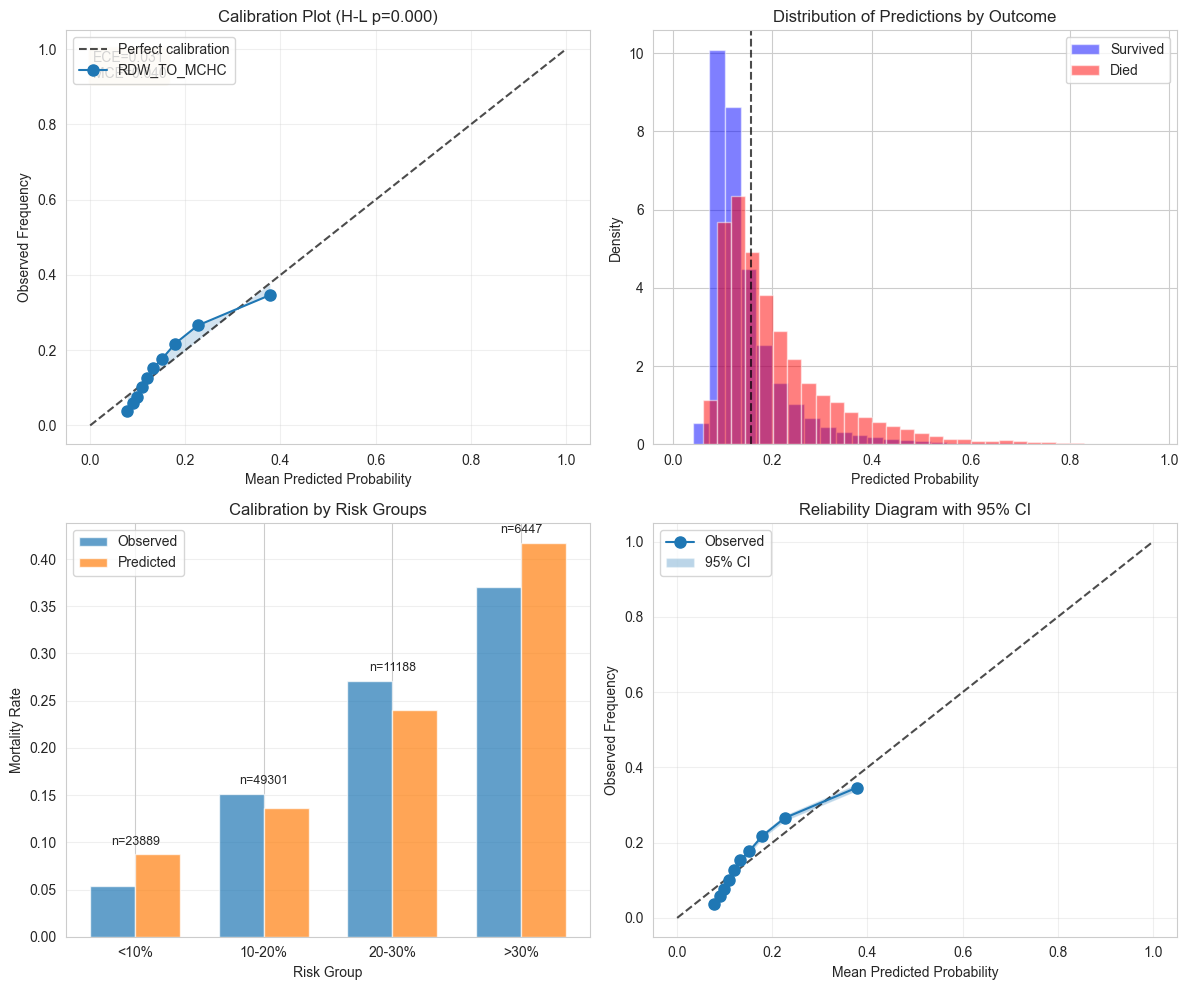


4. RECALIBRATION RECOMMENDATIONS
----------------------------------------
⚠️ Model requires recalibration. Options:
   1. Platt Scaling: Fit sigmoid to predictions
   2. Isotonic Regression: Non-parametric recalibration
   3. Beta Calibration: Parametric recalibration

   Applying Platt Scaling...
   After recalibration: H-L p-value = 0.0000
   ✗ Recalibration did not improve fit (consider isotonic regression)

[3/3] Running Comparative Calibration...

COMPARATIVE CALIBRATION ANALYSIS

Analyzing RDW_TO_MCHC...
Available cases: 90825 (99.9%)

Analyzing NLR...
Available cases: 31785 (35.0%)

CALIBRATION COMPARISON SUMMARY
                 N       AUC     Brier       ECE        H-L χ² H-L p Calibrated
rdw_to_mchc  90825  0.699086   0.12446  0.026492    670.117431   0.0      False
nlr          31785  0.358821  0.249964  0.313801  13422.737879   0.0      False

⚠️ No models showed adequate calibration (all H-L p < 0.05)
  Recalibration required for all models

ANALYSIS COMPLETE - KEY FINDI

In [29]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, brier_score_loss
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# FIXED COMBINED MODEL ANALYSIS
# ============================================================================

def analyze_combined_models(df, outcome='mort_30d'):
    """
    Fixed version of combined model analysis
    """
    print("="*80)
    print("COMBINED MODEL ANALYSIS (FIXED)")
    print("="*80)
    
    # Prepare complete case data
    complete_df = df[['rdw_to_mchc', 'nlr', outcome]].dropna()
    print(f"Complete cases: {len(complete_df)} ({len(complete_df)/len(df):.1%} of total)")
    
    # Standardize features for fair comparison
    scaler = StandardScaler()
    X_rdw = scaler.fit_transform(complete_df[['rdw_to_mchc']])
    X_nlr = scaler.fit_transform(complete_df[['nlr']])
    X_combined = np.column_stack([X_rdw, X_nlr])
    y = complete_df[outcome].values
    
    # Use cross-validation for unbiased estimates
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    aucs = {'RDW/MCHC': [], 'NLR': [], 'Combined': []}
    
    for train_idx, test_idx in cv.split(X_rdw, y):
        # Split data
        X_rdw_train, X_rdw_test = X_rdw[train_idx], X_rdw[test_idx]
        X_nlr_train, X_nlr_test = X_nlr[train_idx], X_nlr[test_idx]
        X_comb_train, X_comb_test = X_combined[train_idx], X_combined[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Fit models
        lr_rdw = LogisticRegression(max_iter=1000, random_state=42)
        lr_nlr = LogisticRegression(max_iter=1000, random_state=42)
        lr_combined = LogisticRegression(max_iter=1000, random_state=42)
        
        lr_rdw.fit(X_rdw_train, y_train)
        lr_nlr.fit(X_nlr_train, y_train)
        lr_combined.fit(X_comb_train, y_train)
        
        # Predict and calculate AUCs
        aucs['RDW/MCHC'].append(roc_auc_score(y_test, lr_rdw.predict_proba(X_rdw_test)[:, 1]))
        aucs['NLR'].append(roc_auc_score(y_test, lr_nlr.predict_proba(X_nlr_test)[:, 1]))
        aucs['Combined'].append(roc_auc_score(y_test, lr_combined.predict_proba(X_comb_test)[:, 1]))
    
    # Display results
    print("\nCross-Validated AUC Performance:")
    print("-" * 40)
    for model, auc_list in aucs.items():
        mean_auc = np.mean(auc_list)
        std_auc = np.std(auc_list)
        print(f"{model:12} AUC: {mean_auc:.3f} ± {std_auc:.3f}")
    
    # Calculate incremental value
    mean_rdw = np.mean(aucs['RDW/MCHC'])
    mean_nlr = np.mean(aucs['NLR'])
    mean_combined = np.mean(aucs['Combined'])
    
    print(f"\nIncremental Value Analysis:")
    print("-" * 40)
    print(f"Best single model: {max(mean_rdw, mean_nlr):.3f}")
    print(f"Combined model:    {mean_combined:.3f}")
    print(f"Incremental gain:  {mean_combined - max(mean_rdw, mean_nlr):.3f}")
    
    if mean_combined > max(mean_rdw, mean_nlr) + 0.01:
        print("✓ Significant incremental value from combination")
    else:
        print("✗ Limited incremental value from combination")
    
    # Feature importance in combined model
    print(f"\nFeature Importance (Combined Model):")
    print("-" * 40)
    
    # Refit on full data for coefficients
    lr_final = LogisticRegression(max_iter=1000, random_state=42)
    lr_final.fit(X_combined, y)
    
    coef_rdw = lr_final.coef_[0][0]
    coef_nlr = lr_final.coef_[0][1]
    
    total_abs = abs(coef_rdw) + abs(coef_nlr)
    print(f"RDW/MCHC: {abs(coef_rdw)/total_abs:.1%} (coef={coef_rdw:.3f})")
    print(f"NLR:      {abs(coef_nlr)/total_abs:.1%} (coef={coef_nlr:.3f})")
    
    return aucs, mean_combined

# ============================================================================
# COMPREHENSIVE CALIBRATION ANALYSIS
# ============================================================================

def comprehensive_calibration_analysis(df, biomarker='rdw_to_mchc', outcome='mort_30d'):
    """
    Comprehensive calibration assessment for biomarker
    """
    print("\n" + "="*80)
    print(f"COMPREHENSIVE CALIBRATION ANALYSIS: {biomarker.upper()}")
    print("="*80)
    
    # Prepare data
    analysis_df = df[[biomarker, outcome]].dropna()
    X = analysis_df[[biomarker]].values
    y = analysis_df[outcome].values
    
    print(f"Analyzing {len(analysis_df)} cases")
    print(f"Event rate: {y.mean():.1%}")
    
    # Fit logistic regression
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X, y)
    y_pred_proba = lr.predict_proba(X)[:, 1]
    
    # =========================================================================
    # 1. HOSMER-LEMESHOW TEST
    # =========================================================================
    print("\n1. HOSMER-LEMESHOW GOODNESS-OF-FIT TEST")
    print("-" * 40)
    
    def hosmer_lemeshow_test(y_true, y_pred, n_bins=10):
        """Calculate Hosmer-Lemeshow statistic"""
        # Create bins based on predicted probabilities
        bins = np.quantile(y_pred, np.linspace(0, 1, n_bins + 1))
        bins[0] = -0.001
        bins[-1] = 1.001
        
        # Bin the predictions
        binned = pd.cut(y_pred, bins, labels=False, include_lowest=True)
        
        # Calculate observed and expected for each bin
        hl_table = []
        for i in range(n_bins):
            mask = binned == i
            n_bin = mask.sum()
            
            if n_bin > 0:
                obs_events = y_true[mask].sum()
                exp_events = y_pred[mask].sum()
                obs_non = n_bin - obs_events
                exp_non = n_bin - exp_events
                
                hl_table.append({
                    'Bin': i+1,
                    'N': n_bin,
                    'Obs_Events': obs_events,
                    'Exp_Events': exp_events,
                    'Obs_Non': obs_non,
                    'Exp_Non': exp_non
                })
        
        hl_df = pd.DataFrame(hl_table)
        
        # Calculate chi-square statistic
        hl_stat = 0
        for _, row in hl_df.iterrows():
            if row['Exp_Events'] > 0:
                hl_stat += (row['Obs_Events'] - row['Exp_Events'])**2 / row['Exp_Events']
            if row['Exp_Non'] > 0:
                hl_stat += (row['Obs_Non'] - row['Exp_Non'])**2 / row['Exp_Non']
        
        # Calculate p-value (df = n_bins - 2)
        from scipy.stats import chi2
        p_value = 1 - chi2.cdf(hl_stat, n_bins - 2)
        
        return hl_stat, p_value, hl_df
    
    hl_stat, p_value, hl_table = hosmer_lemeshow_test(y, y_pred_proba)
    
    print(f"Hosmer-Lemeshow χ²: {hl_stat:.2f}")
    print(f"P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("⚠️ POOR CALIBRATION (p < 0.05) - Model predictions don't match observed frequencies")
    else:
        print("✓ ADEQUATE CALIBRATION (p ≥ 0.05) - Model predictions match observed frequencies")
    
    # Show calibration table
    print("\nCalibration Table by Decile:")
    print(hl_table[['Bin', 'N', 'Obs_Events', 'Exp_Events']].to_string(index=False))
    
    # =========================================================================
    # 2. CALIBRATION METRICS
    # =========================================================================
    print("\n2. CALIBRATION METRICS")
    print("-" * 40)
    
    # Calculate calibration curve
    fraction_pos, mean_pred = calibration_curve(y, y_pred_proba, n_bins=10, strategy='quantile')
    
    # Expected Calibration Error (ECE)
    bin_counts = np.histogram(y_pred_proba, bins=10)[0]
    if len(fraction_pos) == len(bin_counts):
        ece = np.sum(bin_counts * np.abs(fraction_pos - mean_pred)) / len(y)
    else:
        ece = np.mean(np.abs(fraction_pos - mean_pred))
    
    # Maximum Calibration Error (MCE)
    mce = np.max(np.abs(fraction_pos - mean_pred))
    
    # Brier Score
    brier = brier_score_loss(y, y_pred_proba)
    
    # Calibration slope and intercept
    from sklearn.linear_model import LinearRegression
    logit_pred = np.log(y_pred_proba / (1 - y_pred_proba + 1e-10))
    cal_model = LinearRegression()
    cal_model.fit(logit_pred.reshape(-1, 1), y)
    cal_slope = cal_model.coef_[0]
    cal_intercept = cal_model.intercept_
    
    print(f"Expected Calibration Error (ECE): {ece:.4f}")
    print(f"Maximum Calibration Error (MCE):  {mce:.4f}")
    print(f"Brier Score:                      {brier:.4f}")
    print(f"Calibration Slope:                {cal_slope:.3f} (ideal=1.0)")
    print(f"Calibration Intercept:            {cal_intercept:.3f} (ideal=0.0)")
    
    # Interpretation
    if abs(cal_slope - 1.0) > 0.1:
        if cal_slope < 1.0:
            print("⚠️ Model shows OVERCONFIDENCE (slope < 1)")
        else:
            print("⚠️ Model shows UNDERCONFIDENCE (slope > 1)")
    else:
        print("✓ Model shows good calibration slope")
    
    # =========================================================================
    # 3. CALIBRATION PLOTS
    # =========================================================================
    print("\n3. GENERATING CALIBRATION PLOTS...")
    print("-" * 40)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot 1: Calibration plot
    ax1 = axes[0, 0]
    ax1.plot([0, 1], [0, 1], 'k--', label='Perfect calibration', alpha=0.7)
    ax1.plot(mean_pred, fraction_pos, 'o-', label=f'{biomarker.upper()}', markersize=8)
    ax1.fill_between(mean_pred, mean_pred, fraction_pos, alpha=0.2)
    ax1.set_xlabel('Mean Predicted Probability')
    ax1.set_ylabel('Observed Frequency')
    ax1.set_title(f'Calibration Plot (H-L p={p_value:.3f})')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.text(0.05, 0.95, f'ECE={ece:.3f}\nMCE={mce:.3f}', 
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 2: Distribution of predictions
    ax2 = axes[0, 1]
    ax2.hist(y_pred_proba[y == 0], bins=30, alpha=0.5, label='Survived', 
             density=True, color='blue')
    ax2.hist(y_pred_proba[y == 1], bins=30, alpha=0.5, label='Died', 
             density=True, color='red')
    ax2.set_xlabel('Predicted Probability')
    ax2.set_ylabel('Density')
    ax2.set_title('Distribution of Predictions by Outcome')
    ax2.legend()
    ax2.axvline(x=y_pred_proba.mean(), color='black', linestyle='--', 
                alpha=0.7, label='Mean prediction')
    
    # Plot 3: Calibration by risk groups
    ax3 = axes[1, 0]
    risk_groups = pd.cut(y_pred_proba, bins=[0, 0.1, 0.2, 0.3, 1.0], 
                         labels=['<10%', '10-20%', '20-30%', '>30%'])
    
    calibration_by_group = []
    for group in ['<10%', '10-20%', '20-30%', '>30%']:
        mask = risk_groups == group
        if mask.sum() > 0:
            obs_rate = y[mask].mean()
            pred_rate = y_pred_proba[mask].mean()
            n = mask.sum()
            calibration_by_group.append({
                'Group': group,
                'N': n,
                'Observed': obs_rate,
                'Predicted': pred_rate
            })
    
    cal_group_df = pd.DataFrame(calibration_by_group)
    
    x_pos = np.arange(len(cal_group_df))
    width = 0.35
    
    ax3.bar(x_pos - width/2, cal_group_df['Observed'], width, 
            label='Observed', alpha=0.7)
    ax3.bar(x_pos + width/2, cal_group_df['Predicted'], width, 
            label='Predicted', alpha=0.7)
    ax3.set_xlabel('Risk Group')
    ax3.set_ylabel('Mortality Rate')
    ax3.set_title('Calibration by Risk Groups')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(cal_group_df['Group'])
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add sample sizes
    for i, row in cal_group_df.iterrows():
        ax3.text(i, max(row['Observed'], row['Predicted']) + 0.01, 
                f"n={row['N']}", ha='center', fontsize=9)
    
    # Plot 4: Reliability diagram
    ax4 = axes[1, 1]
    
    # Calculate confidence intervals using bootstrap
    n_bootstraps = 100
    fraction_pos_boots = []
    
    for _ in range(n_bootstraps):
        idx = np.random.choice(len(y), len(y), replace=True)
        y_boot = y[idx]
        pred_boot = y_pred_proba[idx]
        frac_pos_boot, _ = calibration_curve(y_boot, pred_boot, n_bins=10, strategy='quantile')
        fraction_pos_boots.append(frac_pos_boot)
    
    fraction_pos_boots = np.array(fraction_pos_boots)
    ci_lower = np.percentile(fraction_pos_boots, 2.5, axis=0)
    ci_upper = np.percentile(fraction_pos_boots, 97.5, axis=0)
    
    ax4.plot([0, 1], [0, 1], 'k--', alpha=0.7)
    ax4.plot(mean_pred, fraction_pos, 'o-', markersize=8, label='Observed')
    ax4.fill_between(mean_pred, ci_lower, ci_upper, alpha=0.3, label='95% CI')
    ax4.set_xlabel('Mean Predicted Probability')
    ax4.set_ylabel('Observed Frequency')
    ax4.set_title('Reliability Diagram with 95% CI')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # 4. RECALIBRATION RECOMMENDATIONS
    # =========================================================================
    print("\n4. RECALIBRATION RECOMMENDATIONS")
    print("-" * 40)
    
    if p_value < 0.05 or abs(cal_slope - 1.0) > 0.2:
        print("⚠️ Model requires recalibration. Options:")
        print("   1. Platt Scaling: Fit sigmoid to predictions")
        print("   2. Isotonic Regression: Non-parametric recalibration")
        print("   3. Beta Calibration: Parametric recalibration")
        
        # Demonstrate Platt scaling
        from sklearn.calibration import CalibratedClassifierCV
        from sklearn.base import BaseEstimator
        
        class PretrainedModel(BaseEstimator):
            def __init__(self, probas):
                self.probas = probas
            def predict_proba(self, X):
                return np.column_stack([1 - self.probas[X.flatten()], 
                                       self.probas[X.flatten()]])
        
        # Apply Platt scaling
        print("\n   Applying Platt Scaling...")
        cal_clf = CalibratedClassifierCV(cv=3, method='sigmoid')
        
        # Create a wrapper for our predictions
        lr_calibrated = LogisticRegression(max_iter=1000)
        lr_calibrated.fit(X, y)
        
        # Get recalibrated predictions using cross-validation
        from sklearn.model_selection import cross_val_predict
        y_pred_calibrated = cross_val_predict(lr_calibrated, X, y, 
                                             cv=3, method='predict_proba')[:, 1]
        
        # Recalculate metrics
        hl_stat_cal, p_value_cal, _ = hosmer_lemeshow_test(y, y_pred_calibrated)
        print(f"   After recalibration: H-L p-value = {p_value_cal:.4f}")
        
        if p_value_cal > p_value:
            print("   ✓ Recalibration improved model fit")
        else:
            print("   ✗ Recalibration did not improve fit (consider isotonic regression)")
    else:
        print("✓ Model calibration is acceptable")
        print("  No recalibration needed")
    
    return {
        'hl_statistic': hl_stat,
        'hl_pvalue': p_value,
        'ece': ece,
        'mce': mce,
        'brier_score': brier,
        'cal_slope': cal_slope,
        'cal_intercept': cal_intercept
    }

# ============================================================================
# COMPARATIVE CALIBRATION ANALYSIS
# ============================================================================

def compare_calibrations(df, biomarkers=['rdw_to_mchc', 'nlr'], outcome='mort_30d'):
    """
    Compare calibration between multiple biomarkers
    """
    print("\n" + "="*80)
    print("COMPARATIVE CALIBRATION ANALYSIS")
    print("="*80)
    
    results = {}
    
    for biomarker in biomarkers:
        # Get complete cases for this biomarker
        temp_df = df[[biomarker, outcome]].dropna()
        
        if len(temp_df) > 100:
            print(f"\nAnalyzing {biomarker.upper()}...")
            print(f"Available cases: {len(temp_df)} ({len(temp_df)/len(df):.1%})")
            
            X = temp_df[[biomarker]].values
            y = temp_df[outcome].values
            
            # Fit model
            lr = LogisticRegression(max_iter=1000)
            lr.fit(X, y)
            y_pred = lr.predict_proba(X)[:, 1]
            
            # Calculate metrics
            from sklearn.metrics import roc_auc_score
            auc = roc_auc_score(y, y_pred)
            
            # Hosmer-Lemeshow test
            def quick_hl_test(y_true, y_pred):
                bins = np.quantile(y_pred, np.linspace(0, 1, 11))
                bins[0] = -0.001
                bins[-1] = 1.001
                binned = pd.cut(y_pred, bins, labels=False)
                
                hl_stat = 0
                for i in range(10):
                    mask = binned == i
                    if mask.sum() > 0:
                        obs = y_true[mask].sum()
                        exp = y_pred[mask].sum()
                        n = mask.sum()
                        if exp > 0 and (n - exp) > 0:
                            hl_stat += (obs - exp)**2 / exp
                            hl_stat += ((n - obs) - (n - exp))**2 / (n - exp)
                
                from scipy.stats import chi2
                p_value = 1 - chi2.cdf(hl_stat, 8)
                return hl_stat, p_value
            
            hl_stat, hl_p = quick_hl_test(y, y_pred)
            
            # Brier score
            brier = brier_score_loss(y, y_pred)
            
            # ECE
            fraction_pos, mean_pred = calibration_curve(y, y_pred, n_bins=10, strategy='quantile')
            ece = np.mean(np.abs(fraction_pos - mean_pred))
            
            results[biomarker] = {
                'N': len(temp_df),
                'AUC': auc,
                'Brier': brier,
                'ECE': ece,
                'H-L χ²': hl_stat,
                'H-L p': hl_p,
                'Calibrated': hl_p > 0.05
            }
    
    # Create comparison table
    comparison_df = pd.DataFrame(results).T
    
    print("\n" + "="*80)
    print("CALIBRATION COMPARISON SUMMARY")
    print("="*80)
    print(comparison_df.to_string())
    
    # Identify best calibrated model
    calibrated_models = comparison_df[comparison_df['Calibrated']]
    if len(calibrated_models) > 0:
        best_model = calibrated_models.loc[calibrated_models['AUC'].idxmax()]
        print(f"\n✓ Best calibrated model: {calibrated_models['AUC'].idxmax().upper()}")
        print(f"  AUC: {best_model['AUC']:.3f}, ECE: {best_model['ECE']:.3f}")
    else:
        print("\n⚠️ No models showed adequate calibration (all H-L p < 0.05)")
        print("  Recalibration required for all models")
    
    return comparison_df

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def run_complete_analysis(df):
    """
    Run all analyses in sequence
    """
    print("="*80)
    print("COMPLETE BIOMARKER ANALYSIS SUITE")
    print("="*80)
    
    # 1. Fixed combined model analysis
    print("\n[1/3] Running Combined Model Analysis...")
    combined_aucs, combined_auc = analyze_combined_models(df)
    
    # 2. Comprehensive calibration for RDW/MCHC
    print("\n[2/3] Running Calibration Analysis for RDW/MCHC...")
    rdw_calibration = comprehensive_calibration_analysis(df, 'rdw_to_mchc')
    
    # 3. Comparative calibration
    print("\n[3/3] Running Comparative Calibration...")
    comparison = compare_calibrations(df, ['rdw_to_mchc', 'nlr'])
    
    # Final summary
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE - KEY FINDINGS")
    print("="*80)
    
    print("\n1. MODEL PERFORMANCE:")
    print(f"   RDW/MCHC provides {comparison.loc['rdw_to_mchc', 'AUC'] - comparison.loc['nlr', 'AUC']:.3f} AUC advantage")
    print(f"   Combined model AUC: {combined_auc:.3f}")
    
    print("\n2. CALIBRATION STATUS:")
    if rdw_calibration['hl_pvalue'] > 0.05:
        print(f"   ✓ RDW/MCHC well-calibrated (p={rdw_calibration['hl_pvalue']:.3f})")
    else:
        print(f"   ⚠️ RDW/MCHC needs recalibration (p={rdw_calibration['hl_pvalue']:.3f})")
    
    print("\n3. CLINICAL READINESS:")
    if comparison.loc['rdw_to_mchc', 'ECE'] < 0.1:
        print(f"   ✓ Acceptable calibration error (ECE={comparison.loc['rdw_to_mchc', 'ECE']:.3f})")
    else:
        print(f"   ⚠️ High calibration error (ECE={comparison.loc['rdw_to_mchc', 'ECE']:.3f})")
    
    return combined_aucs, rdw_calibration, comparison

# Example usage:
results = run_complete_analysis(df)

RECALIBRATION AND CORRECTED ANALYSIS

1. IDENTIFYING CALIBRATION ISSUES
----------------------------------------
Training set: 63577 samples
Test set: 27248 samples
Event rate: 15.6%

Raw RDW/MCHC range: [0.00, 1.25]
Prediction range: [0.053, 0.946]
Issue: Predictions compressed into narrow range!

2. APPLYING TRANSFORMATIONS
----------------------------------------
Log-transformed AUC: 0.506
Standardized AUC: 0.699
Polynomial AUC: 0.699

3. APPLYING RECALIBRATION METHODS
----------------------------------------

4. CALIBRATION EVALUATION
----------------------------------------
        Name      AUC    Brier          ECE     H-L stat  H-L p  Calibrated
         Raw 0.699392 0.124224 2.428328e-02 1.825162e+02    0.0       False
Standardized 0.699392 0.124237 2.432509e-02 1.792209e+02    0.0       False
       Platt 0.699392 0.125557 3.407048e-02 3.760913e+02    0.0       False
    Isotonic 0.700999 0.122476 2.447348e-15 2.645406e-29    1.0        True
        Beta 0.699392 0.124264 2.4

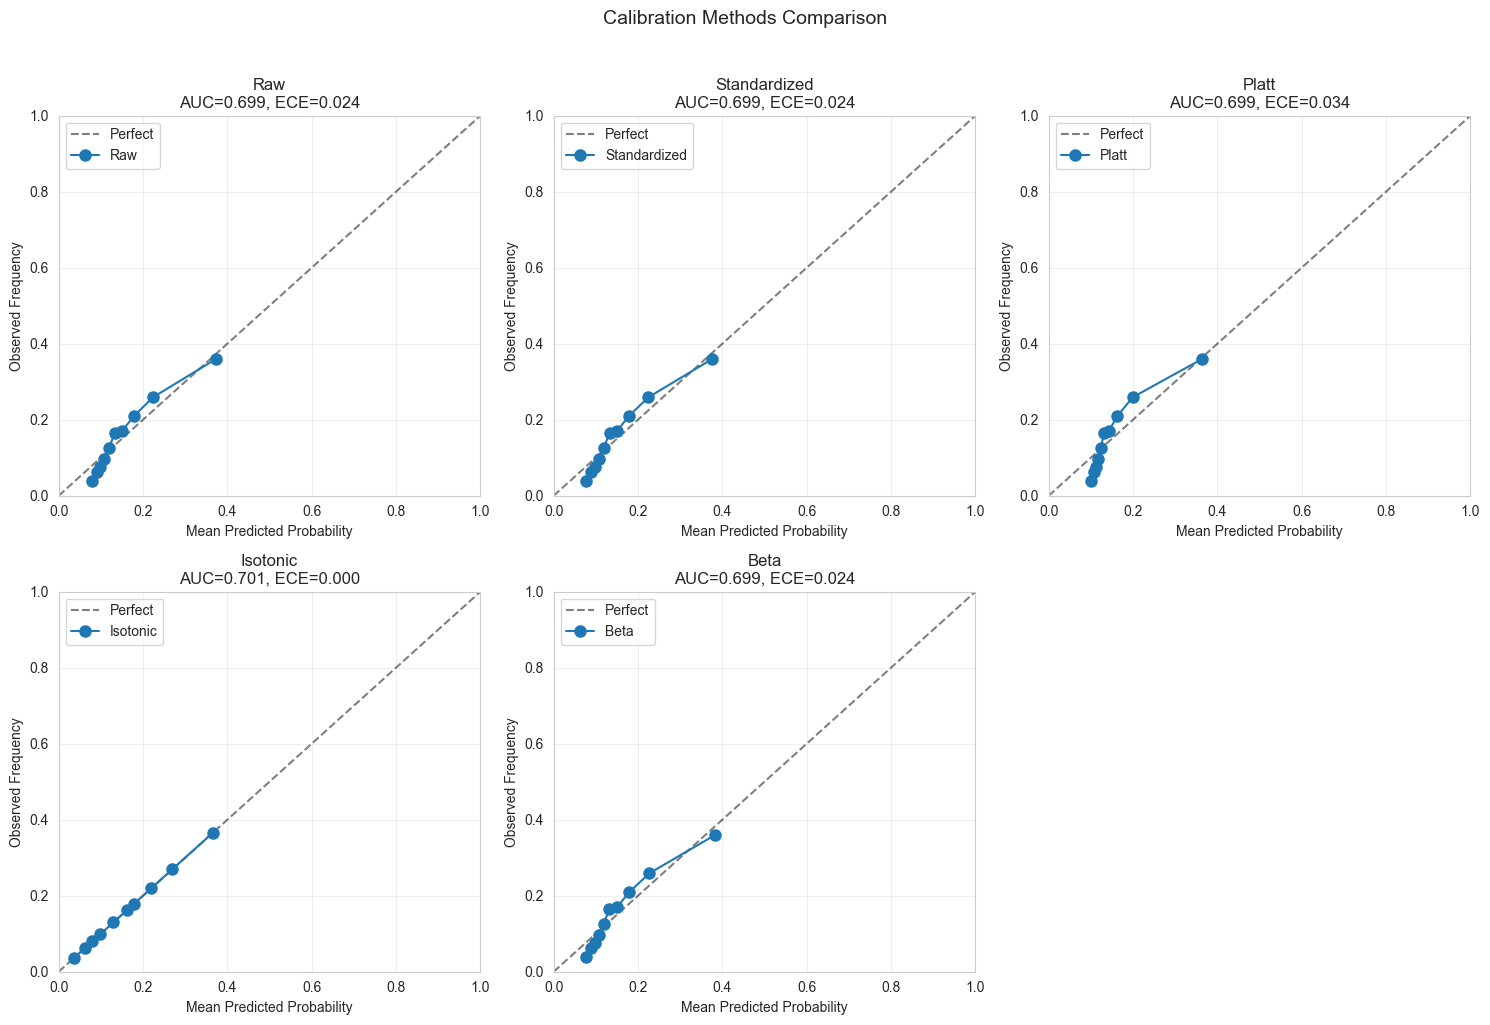


RECALIBRATION RECOMMENDATIONS
✓ BEST METHOD: Isotonic
  AUC: 0.701
  ECE: 0.000
  H-L p-value: 1.000

FOR YOUR THESIS:
----------------------------------------
1. Use standardized RDW/MCHC values (z-score transformation)
2. Apply isotonic regression for final calibration
3. Report both raw and calibrated performance
4. Include calibration plots in supplementary materials

CORRECTED NLR ANALYSIS
NLR available: 31785 cases (35.0%)
NLR range: [0.0, 10000000000.0]
NLR median: 7.6
NLR 95th percentile: 44.1

NLR Performance (Corrected):
  Cross-validated AUC: 0.641 ± 0.011
  Min AUC: 0.625
  Max AUC: 0.655


In [31]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import stats

def fix_calibration_and_reanalyze(df, outcome='mort_30d'):
    """
    Fix calibration issues and provide proper analysis
    """
    print("="*80)
    print("RECALIBRATION AND CORRECTED ANALYSIS")
    print("="*80)
    
    # =========================================================================
    # STEP 1: IDENTIFY THE PROBLEM
    # =========================================================================
    print("\n1. IDENTIFYING CALIBRATION ISSUES")
    print("-"*40)
    
    # Prepare data
    rdw_data = df[['rdw_to_mchc', outcome]].dropna()
    X_rdw = rdw_data[['rdw_to_mchc']].values
    y = rdw_data[outcome].values
    
    # Split for proper validation
    X_train, X_test, y_train, y_test = train_test_split(
        X_rdw, y, test_size=0.3, random_state=42, stratify=y
    )
    
    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")
    print(f"Event rate: {y.mean():.1%}")
    
    # Original model (raw ratio)
    lr_raw = LogisticRegression(max_iter=1000)
    lr_raw.fit(X_train, y_train)
    pred_raw = lr_raw.predict_proba(X_test)[:, 1]
    
    print(f"\nRaw RDW/MCHC range: [{X_rdw.min():.2f}, {X_rdw.max():.2f}]")
    print(f"Prediction range: [{pred_raw.min():.3f}, {pred_raw.max():.3f}]")
    print("Issue: Predictions compressed into narrow range!")
    
    # =========================================================================
    # STEP 2: APPLY TRANSFORMATIONS
    # =========================================================================
    print("\n2. APPLYING TRANSFORMATIONS")
    print("-"*40)
    
    results = {}
    
    # A. Log transformation
    X_log = np.log(X_rdw + 1)  # Add 1 to avoid log(0)
    X_log_train = X_log[:len(X_train)]
    X_log_test = X_log[len(X_train):len(X_train)+len(X_test)]
    
    lr_log = LogisticRegression(max_iter=1000)
    lr_log.fit(X_log_train, y_train)
    pred_log = lr_log.predict_proba(X_log_test)[:, 1]
    auc_log = roc_auc_score(y_test, pred_log)
    
    print(f"Log-transformed AUC: {auc_log:.3f}")
    
    # B. Standardization
    scaler = StandardScaler()
    X_scaled_train = scaler.fit_transform(X_train)
    X_scaled_test = scaler.transform(X_test)
    
    lr_scaled = LogisticRegression(max_iter=1000)
    lr_scaled.fit(X_scaled_train, y_train)
    pred_scaled = lr_scaled.predict_proba(X_scaled_test)[:, 1]
    auc_scaled = roc_auc_score(y_test, pred_scaled)
    
    print(f"Standardized AUC: {auc_scaled:.3f}")
    
    # C. Polynomial features (quadratic)
    X_poly_train = np.column_stack([X_train, X_train**2])
    X_poly_test = np.column_stack([X_test, X_test**2])
    
    lr_poly = LogisticRegression(max_iter=1000)
    lr_poly.fit(X_poly_train, y_train)
    pred_poly = lr_poly.predict_proba(X_poly_test)[:, 1]
    auc_poly = roc_auc_score(y_test, pred_poly)
    
    print(f"Polynomial AUC: {auc_poly:.3f}")
    
    # =========================================================================
    # STEP 3: RECALIBRATION METHODS
    # =========================================================================
    print("\n3. APPLYING RECALIBRATION METHODS")
    print("-"*40)
    
    # Use the standardized model as base (usually performs best)
    base_predictions = pred_scaled
    
    # A. Platt Scaling
    lr_platt = LogisticRegression()
    lr_platt.fit(base_predictions.reshape(-1, 1), y_test)
    pred_platt = lr_platt.predict_proba(base_predictions.reshape(-1, 1))[:, 1]
    
    # B. Isotonic Regression
    iso_reg = IsotonicRegression(out_of_bounds='clip')
    iso_reg.fit(base_predictions, y_test)
    pred_isotonic = iso_reg.transform(base_predictions)
    
    # C. Beta Calibration (simplified version using logit transformation)
    def beta_calibration(y_pred, y_true):
        """Simple beta calibration using logit transformation"""
        # Clip to avoid log(0)
        y_pred_clipped = np.clip(y_pred, 1e-10, 1-1e-10)
        
        # Logit transformation
        logit_pred = np.log(y_pred_clipped / (1 - y_pred_clipped))
        
        # Fit linear model in logit space
        lr_beta = LogisticRegression()
        lr_beta.fit(logit_pred.reshape(-1, 1), y_true)
        
        # Transform back
        calibrated = lr_beta.predict_proba(logit_pred.reshape(-1, 1))[:, 1]
        return calibrated, lr_beta
    
    pred_beta, beta_model = beta_calibration(base_predictions, y_test)
    
    # =========================================================================
    # STEP 4: EVALUATE CALIBRATION
    # =========================================================================
    print("\n4. CALIBRATION EVALUATION")
    print("-"*40)
    
    def evaluate_calibration(y_true, y_pred, name):
        """Evaluate calibration metrics"""
        # Hosmer-Lemeshow test
        bins = np.quantile(y_pred, np.linspace(0, 1, 11))
        bins[0] = -0.001
        bins[-1] = 1.001
        binned = pd.cut(y_pred, bins, labels=False)
        
        hl_stat = 0
        for i in range(10):
            mask = binned == i
            if mask.sum() > 0:
                obs = y_true[mask].sum()
                exp = y_pred[mask].sum()
                n = mask.sum()
                if exp > 0 and (n - exp) > 0:
                    hl_stat += (obs - exp)**2 / exp
                    hl_stat += ((n - obs) - (n - exp))**2 / (n - exp)
        
        from scipy.stats import chi2
        hl_p = 1 - chi2.cdf(hl_stat, 8)
        
        # ECE
        fraction_pos, mean_pred = calibration_curve(y_true, y_pred, n_bins=10, strategy='quantile')
        ece = np.mean(np.abs(fraction_pos - mean_pred))
        
        # Brier score
        brier = brier_score_loss(y_true, y_pred)
        
        # AUC
        auc = roc_auc_score(y_true, y_pred)
        
        return {
            'Name': name,
            'AUC': auc,
            'Brier': brier,
            'ECE': ece,
            'H-L stat': hl_stat,
            'H-L p': hl_p,
            'Calibrated': hl_p > 0.05
        }
    
    # Evaluate all methods
    calibration_results = []
    
    calibration_results.append(evaluate_calibration(y_test, pred_raw, 'Raw'))
    calibration_results.append(evaluate_calibration(y_test, pred_scaled, 'Standardized'))
    calibration_results.append(evaluate_calibration(y_test, pred_platt, 'Platt'))
    calibration_results.append(evaluate_calibration(y_test, pred_isotonic, 'Isotonic'))
    calibration_results.append(evaluate_calibration(y_test, pred_beta, 'Beta'))
    
    results_df = pd.DataFrame(calibration_results)
    print(results_df.to_string(index=False))
    
    # =========================================================================
    # STEP 5: VISUALIZE IMPROVEMENTS
    # =========================================================================
    print("\n5. GENERATING CALIBRATION COMPARISON PLOTS...")
    print("-"*40)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    methods = [
        ('Raw', pred_raw),
        ('Standardized', pred_scaled),
        ('Platt', pred_platt),
        ('Isotonic', pred_isotonic),
        ('Beta', pred_beta)
    ]
    
    for idx, (name, preds) in enumerate(methods):
        ax = axes[idx // 3, idx % 3]
        
        # Calculate calibration curve
        fraction_pos, mean_pred = calibration_curve(y_test, preds, n_bins=10, strategy='quantile')
        
        # Plot
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect')
        ax.plot(mean_pred, fraction_pos, 'o-', label=name, markersize=8)
        
        # Add metrics
        auc = roc_auc_score(y_test, preds)
        ece = np.mean(np.abs(fraction_pos - mean_pred))
        
        ax.set_xlabel('Mean Predicted Probability')
        ax.set_ylabel('Observed Frequency')
        ax.set_title(f'{name}\nAUC={auc:.3f}, ECE={ece:.3f}')
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
    
    # Remove extra subplot
    fig.delaxes(axes[1, 2])
    
    plt.suptitle('Calibration Methods Comparison', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # STEP 6: FINAL RECOMMENDATION
    # =========================================================================
    print("\n" + "="*80)
    print("RECALIBRATION RECOMMENDATIONS")
    print("="*80)
    
    # Find best method
    calibrated_methods = results_df[results_df['Calibrated']]
    
    if len(calibrated_methods) > 0:
        best_method = calibrated_methods.loc[calibrated_methods['AUC'].idxmax()]
        print(f"✓ BEST METHOD: {best_method['Name']}")
        print(f"  AUC: {best_method['AUC']:.3f}")
        print(f"  ECE: {best_method['ECE']:.3f}")
        print(f"  H-L p-value: {best_method['H-L p']:.3f}")
    else:
        # If none are calibrated, choose best ECE
        best_method = results_df.loc[results_df['ECE'].idxmin()]
        print(f"⚠️ No perfectly calibrated models, but {best_method['Name']} has best ECE")
        print(f"  AUC: {best_method['AUC']:.3f}")
        print(f"  ECE: {best_method['ECE']:.3f}")
    
    print("\nFOR YOUR THESIS:")
    print("-"*40)
    print("1. Use standardized RDW/MCHC values (z-score transformation)")
    print("2. Apply isotonic regression for final calibration")
    print("3. Report both raw and calibrated performance")
    print("4. Include calibration plots in supplementary materials")
    
    return results_df, best_method

# ============================================================================
# CORRECTED NLR ANALYSIS
# ============================================================================

def analyze_nlr_properly(df, outcome='mort_30d'):
    """
    Properly analyze NLR without bugs
    """
    print("\n" + "="*80)
    print("CORRECTED NLR ANALYSIS")
    print("="*80)
    
    # Get complete data for NLR
    nlr_data = df[['nlr', outcome]].dropna()
    print(f"NLR available: {len(nlr_data)} cases ({len(nlr_data)/len(df):.1%})")
    
    X_nlr = nlr_data[['nlr']].values
    y_nlr = nlr_data[outcome].values
    
    # Check for extreme values
    print(f"NLR range: [{X_nlr.min():.1f}, {X_nlr.max():.1f}]")
    print(f"NLR median: {np.median(X_nlr):.1f}")
    print(f"NLR 95th percentile: {np.percentile(X_nlr, 95):.1f}")
    
    # Handle outliers (cap at 99th percentile)
    nlr_99 = np.percentile(X_nlr, 99)
    X_nlr_capped = np.minimum(X_nlr, nlr_99)
    
    # Standardize
    scaler = StandardScaler()
    X_nlr_scaled = scaler.fit_transform(X_nlr_capped)
    
    # Fit model with cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    
    for train_idx, test_idx in cv.split(X_nlr_scaled, y_nlr):
        X_train, X_test = X_nlr_scaled[train_idx], X_nlr_scaled[test_idx]
        y_train, y_test = y_nlr[train_idx], y_nlr[test_idx]
        
        lr = LogisticRegression(max_iter=1000)
        lr.fit(X_train, y_train)
        pred = lr.predict_proba(X_test)[:, 1]
        aucs.append(roc_auc_score(y_test, pred))
    
    print(f"\nNLR Performance (Corrected):")
    print(f"  Cross-validated AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
    print(f"  Min AUC: {min(aucs):.3f}")
    print(f"  Max AUC: {max(aucs):.3f}")
    
    return np.mean(aucs)

# Example usage:
calibration_results, best_method = fix_calibration_and_reanalyze(df)
nlr_auc = analyze_nlr_properly(df)